#מגישים:


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from transformers import pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel






C:\Users\97254\anaconda3.1\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# 2. pre-processing

In [2]:


file_path = "_chat.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    messages = file.readlines()

sender_names = []
message_timestamps = []
message_texts = []
line_numbers = []
formatting_issues = []

current_message = None  # Variable to store the current message being constructed
current_sender = None
current_timestamp = None

for i, message in enumerate(messages):
    # If the message starts with a timestamp, it's a new message
    match = re.match(r'^\[(\d+\.\d+\.\d+), (\d+:\d+:\d+)\] (.+?): (.*)$', message)
    if match:
        timestamp = match.group(1) + ', ' + match.group(2)
        name = match.group(3)
        message_text = match.group(4)

        if current_message is not None:
            # Append the current message to the list if it exists
            sender_names.append(current_sender)
            message_timestamps.append(current_timestamp)
            message_texts.append(current_message)
            line_numbers.append(i - 1)  # Store line number for the previous message

        # Update current message information
        current_sender = name
        current_timestamp = timestamp
        current_message = message_text.strip()  # Initialize current message
    elif current_message is not None:
        # Append lines to the current message if it exists
        current_message += ' ' + message.strip()
    else:
        # If line doesn't match expected format and there's no current message, store it in the formatting issues list
        formatting_issues.append((i, message))

# Add the last message to the lists
if current_message is not None:
    sender_names.append(current_sender)
    message_timestamps.append(current_timestamp)
    message_texts.append(current_message)
    line_numbers.append(i)  # Store line number for the last message

# Create DataFrame for main data
df = pd.DataFrame({
    'Sender': sender_names,
    'Timestamp': message_timestamps,
    'Message': message_texts,
    'Line_Number': line_numbers
})

# Create DataFrame for formatting issues
df_formatting_issues = pd.DataFrame({
    'Line_Number': [issue[0] for issue in formatting_issues],
    'Message': [issue[1] for issue in formatting_issues]
})

# Display summary
print("Number of rows in main DataFrame:", len(df))


Number of rows in main DataFrame: 1566


In [3]:

# Define the emoji pattern
emoji_pattern = r'[^\w\s\.\?!]'

# Define the image pattern
image_pattern = r'\b\w+\.(jpg|jpeg|png|gif|webp)\b'

# Define the URL pattern
url_pattern = r'https?://\S+'

english_pattern = r'[a-zA-Z]'

# Define the number pattern to match numbers with 3 digits or more
number_pattern = r'\b\d{3,}\b'

# Define filtering conditions
filter_condition = (
    ~df['Message'].str.contains(image_pattern, case=False) &  # Exclude messages with image filenames
    ~df['Message'].str.contains(english_pattern) &  # Exclude messages with English characters
    ~df['Message'].str.contains(url_pattern) &  # Exclude messages with URLs
    ~df['Message'].str.contains(number_pattern)  # Exclude messages with numbers with 3 digits or more
)

# Apply filtering condition to the DataFrame
df_filtered = df[filter_condition]

# Remove emojis from messages
df_filtered['Message'] = df_filtered['Message'].apply(lambda x: re.sub(emoji_pattern, '', x))



# Phrases to remove
phrases_to_remove = [r'הודעה זו נמחקה', r'הסיר']

# Remove messages containing specified phrases
for phrase in phrases_to_remove:
    df_filtered = df_filtered[~df_filtered['Message'].str.contains(phrase)]

# Display the filtered DataFrame
df_filtered
import re

# Define the emoji pattern
emoji_pattern = r'[^\w\s\.\?!]'

# Define the image pattern
image_pattern = r'\b\w+\.(jpg|jpeg|png|gif|webp)\b'

# Define the URL pattern
url_pattern = r'https?://\S+'

english_pattern = r'[a-zA-Z]'

# Define the number pattern to match numbers with 3 digits or more
number_pattern = r'\b\d{3,}\b'

# Define filtering conditions
filter_condition = (
    ~df['Message'].str.contains(image_pattern, case=False) &  # Exclude messages with image filenames
    ~df['Message'].str.contains(english_pattern) &  # Exclude messages with English characters
    ~df['Message'].str.contains(url_pattern) &  # Exclude messages with URLs
    ~df['Message'].str.contains(number_pattern)  # Exclude messages with numbers with 3 digits or more
)

# Apply filtering condition to the DataFrame
df_filtered = df[filter_condition]

# Remove emojis from messages
df_filtered['Message'] = df_filtered['Message'].apply(lambda x: re.sub(emoji_pattern, '', x))

# Phrases to remove
phrases_to_remove = [r'הודעה זו נמחקה', r'הסיר']

# Remove messages containing specified phrases
for phrase in phrases_to_remove:
    df_filtered = df_filtered[~df_filtered['Message'].str.contains(phrase)]

# Drop rows with empty messages
df_filtered = df_filtered[df_filtered['Message'].notna()]

# Check if there are still messages after dropping empty ones
if len(df_filtered) == 0:
    print("No non-empty messages remaining. Exiting.")
    # You may choose to exit the script or handle the case appropriately.

# Display the filtered DataFrame
df_filtered


C:\Users\97254\AppData\Local\Temp\ipykernel_26704\4110550890.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~df['Message'].str.contains(image_pattern, case=False) &  # Exclude messages with image filenames
C:\Users\97254\AppData\Local\Temp\ipykernel_26704\4110550890.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Message'] = df_filtered['Message'].apply(lambda x: re.sub(emoji_pattern, '', x))
C:\Users\97254\AppData\Local\Temp\ipykernel_26704\4110550890.py:58: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~df['Message'].str.contains(image_pattern, c

Sender             Timestamp  \
1                רועי מרלי   21.8.2023, 17:32:38   
2     יעל גורן (מפילדלפיה)   8.10.2023, 22:22:51   
9                שחר דישבק   23.10.2023, 9:56:43   
10            חזי לוי מהלב   23.10.2023, 9:59:44   
11               שחר דישבק  23.10.2023, 10:04:59   
...                    ...                   ...   
1561         דורית בן שלום   7.11.2023, 11:40:51   
1562            רונן ברנוי   7.11.2023, 11:41:06   
1563             יעקב וובר   7.11.2023, 11:41:16   
1564              ~ Meitav   7.11.2023, 12:00:33   
1565        לירית שפיר שמש   7.11.2023, 13:11:19   

                                                Message  Line_Number  
1     סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...            5  
2     האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...            9  
9     בוקר טוב אני רוצה לדווח לאחא וקיבלתי תשובה אוט...           18  
10    בוקר טוב . יחזקאל מהלב  האם יש משהו שנוכל לעזור ?           20  
11    אלא אם אתם מתעסקים בתמלולתרגום דרך אחא חוששתני...           21  
...                                                 ...          ...  
1561  מה שהצעתי . מי שבחרדות עקב המצב שירכוש שעון וי...         2727  
1562                         יאללה חמודיםות... יאללה...         2728  
1563             כמו שאמרתי אין השבע יודע את מצוקת הרעב         2729  
1564  כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...         2730  
1565  שלום לכולם כולנו בימים האלו רגישים והעצבים שלנ...         2739  

[1306 rows x 4 columns]

In [4]:
df_filtered.reset_index(drop=True, inplace=True)
df_filtered


Sender             Timestamp  \
0                רועי מרלי   21.8.2023, 17:32:38   
1     יעל גורן (מפילדלפיה)   8.10.2023, 22:22:51   
2                שחר דישבק   23.10.2023, 9:56:43   
3             חזי לוי מהלב   23.10.2023, 9:59:44   
4                שחר דישבק  23.10.2023, 10:04:59   
...                    ...                   ...   
1301         דורית בן שלום   7.11.2023, 11:40:51   
1302            רונן ברנוי   7.11.2023, 11:41:06   
1303             יעקב וובר   7.11.2023, 11:41:16   
1304              ~ Meitav   7.11.2023, 12:00:33   
1305        לירית שפיר שמש   7.11.2023, 13:11:19   

                                                Message  Line_Number  
0     סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...            5  
1     האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...            9  
2     בוקר טוב אני רוצה לדווח לאחא וקיבלתי תשובה אוט...           18  
3     בוקר טוב . יחזקאל מהלב  האם יש משהו שנוכל לעזור ?           20  
4     אלא אם אתם מתעסקים בתמלולתרגום דרך אחא חוששתני...           21  
...                                                 ...          ...  
1301  מה שהצעתי . מי שבחרדות עקב המצב שירכוש שעון וי...         2727  
1302                         יאללה חמודיםות... יאללה...         2728  
1303             כמו שאמרתי אין השבע יודע את מצוקת הרעב         2729  
1304  כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...         2730  
1305  שלום לכולם כולנו בימים האלו רגישים והעצבים שלנ...         2739  

[1306 rows x 4 columns]

In [5]:

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the text data and transform the text into a numerical matrix
X = vectorizer.fit_transform(df_filtered['Message'])

# Convert the matrix to an array
X_array = X.toarray()

# Display the features
feature_names = vectorizer.get_feature_names_out()
print("Number of features:", len(feature_names))
print("Features:", feature_names)


Number of features: 5245
Features: ['07' '10' '11' ... 'תתקן' 'תתקשר' 'תתרום']


In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataframe as df_filtered

# Tokenize the messages into words
df_filtered['Tokenized_Message'] = df_filtered['Message'].apply(lambda x: re.findall(r'\b\w+\b', x))

# Remove stop words
stop_words = set(stopwords.words('hebrew'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df_filtered['Tokenized_Message_No_Stopwords'] = df_filtered['Tokenized_Message'].apply(remove_stopwords)

# Convert the tokenized messages without stop words into strings
tokenized_messages_strings = df_filtered['Tokenized_Message_No_Stopwords'].apply(lambda x: ' '.join(x))

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the tokenized messages and transform them into a numerical matrix
X = vectorizer.fit_transform(tokenized_messages_strings)

# Convert the matrix to a DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bow_df



07  10  11  1100  12  13  14  15  18  20  ...  תתחשב  תתמודד  תתמודדו  \
0      0   0   0     0   0   0   1   0   0   0  ...      0       0        0   
1      0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
2      0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
3      0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
4      0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
...   ..  ..  ..   ...  ..  ..  ..  ..  ..  ..  ...    ...     ...      ...   
1301   0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
1302   0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
1303   0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
1304   0   0   0     0   0   0   0   0   0   0  ...      0       0        0   
1305   0   0   0     0   0   0   0   0   0   0  ...      0       0        0   

      תתן  תתפלא  תתקבל  תתקדמי  תתקן  תתקשר  תתרום  
0       0      0      0       0     0      0      0  
1       0      0      0       0     0      0      0  
2       0      0      0       0     0      0      0  
3       0      0      0       0     0      0      0  
4       0      0      0       0     0      0      0  
...   ...    ...    ...     ...   ...    ...    ...  
1301    0      0      0       0     0      0      0  
1302    0      0      0       0     0      0      0  
1303    0      0      0       0     0      0      0  
1304    0      0      0       0     0      0      0  
1305    0      0      0       0     0      0      0  

[1306 rows x 5099 columns]

In [7]:
df_filtered

Sender             Timestamp  \
0                רועי מרלי   21.8.2023, 17:32:38   
1     יעל גורן (מפילדלפיה)   8.10.2023, 22:22:51   
2                שחר דישבק   23.10.2023, 9:56:43   
3             חזי לוי מהלב   23.10.2023, 9:59:44   
4                שחר דישבק  23.10.2023, 10:04:59   
...                    ...                   ...   
1301         דורית בן שלום   7.11.2023, 11:40:51   
1302            רונן ברנוי   7.11.2023, 11:41:06   
1303             יעקב וובר   7.11.2023, 11:41:16   
1304              ~ Meitav   7.11.2023, 12:00:33   
1305        לירית שפיר שמש   7.11.2023, 13:11:19   

                                                Message  Line_Number  \
0     סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...            5   
1     האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...            9   
2     בוקר טוב אני רוצה לדווח לאחא וקיבלתי תשובה אוט...           18   
3     בוקר טוב . יחזקאל מהלב  האם יש משהו שנוכל לעזור ?           20   
4     אלא אם אתם מתעסקים בתמלולתרגום דרך אחא חוששתני...           21   
...                                                 ...          ...   
1301  מה שהצעתי . מי שבחרדות עקב המצב שירכוש שעון וי...         2727   
1302                         יאללה חמודיםות... יאללה...         2728   
1303             כמו שאמרתי אין השבע יודע את מצוקת הרעב         2729   
1304  כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...         2730   
1305  שלום לכולם כולנו בימים האלו רגישים והעצבים שלנ...         2739   

                                      Tokenized_Message  \
0     [סקר, חברת, שידורית, זכתה, במכרז, של, משרד, הר...   
1     [האם, יש, אפשרות, באפליקציה, לשנות, את, צליל, ...   
2     [בוקר, טוב, אני, רוצה, לדווח, לאחא, וקיבלתי, ת...   
3     [בוקר, טוב, יחזקאל, מהלב, האם, יש, משהו, שנוכל...   
4     [אלא, אם, אתם, מתעסקים, בתמלולתרגום, דרך, אחא,...   
...                                                 ...   
1301  [מה, שהצעתי, מי, שבחרדות, עקב, המצב, שירכוש, ש...   
1302                           [יאללה, חמודיםות, יאללה]   
1303    [כמו, שאמרתי, אין, השבע, יודע, את, מצוקת, הרעב]   
1304  [כי, היא, חכמה, גדולה, והבנה, שלה, מושלמת, והב...   
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...   

                         Tokenized_Message_No_Stopwords  
0     [סקר, חברת, שידורית, זכתה, במכרז, משרד, הרווחה...  
1     [האם, אפשרות, באפליקציה, לשנות, צליל, ההתראה, ...  
2     [בוקר, טוב, רוצה, לדווח, לאחא, וקיבלתי, תשובה,...  
3     [בוקר, טוב, יחזקאל, מהלב, האם, משהו, שנוכל, לע...  
4        [אלא, מתעסקים, בתמלולתרגום, אחא, חוששתני, שלא]  
...                                                 ...  
1301  [שהצעתי, שבחרדות, עקב, המצב, שירכוש, שעון, ויז...  
1302                           [יאללה, חמודיםות, יאללה]  
1303                  [שאמרתי, השבע, יודע, מצוקת, הרעב]  
1304   [חכמה, גדולה, והבנה, מושלמת, והבנה, לוקה, בחוסר]  
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...  

[1306 rows x 6 columns]

# 3.Eda


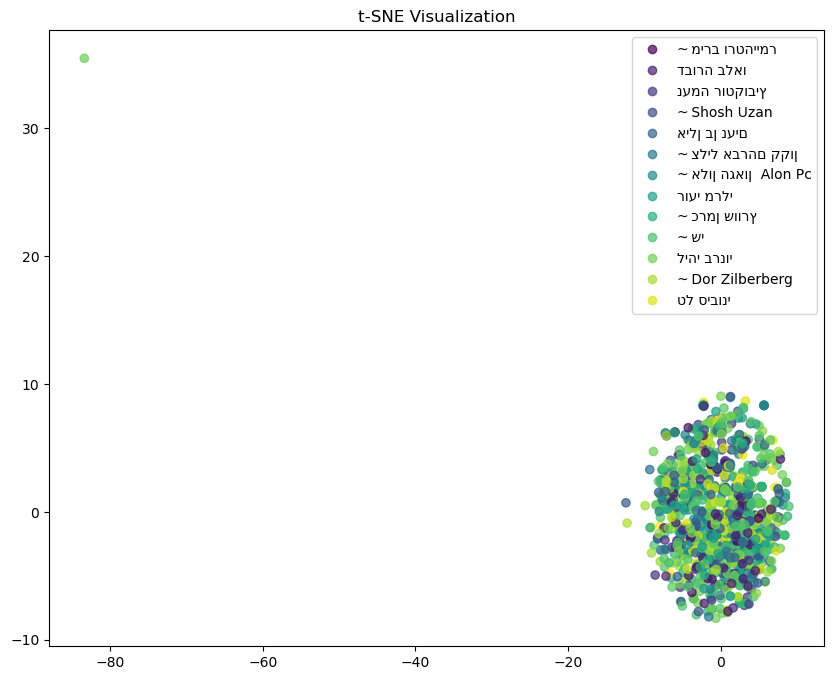

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming X_array is your data after CountVectorizer
# You can use the original messages or the bag-of-words representation, whichever you prefer
X_for_tsne = X_array

# Initialize t-SNE with desired parameters (e.g., perplexity and number of iterations)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Fit and transform the data
tsne_result = tsne.fit_transform(X_for_tsne)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Add Sender information to the t-SNE DataFrame
tsne_df['Sender'] = df_filtered['Sender']

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x=tsne_df['Dimension 1'], y=tsne_df['Dimension 2'], c=tsne_df['Sender'].astype('category').cat.codes, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.legend(handles=scatter.legend_elements()[0], labels=set(tsne_df['Sender']))
plt.show()


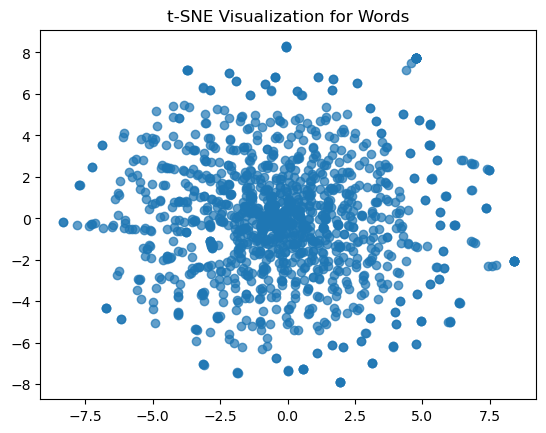

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming df_filtered is your DataFrame
messages = df_filtered['Tokenized_Message_No_Stopwords'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform the messages into TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(messages)

# Apply t-SNE on the TF-IDF matrix with init='random'
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, init='random')
tsne_result = tsne.fit_transform(tfidf_matrix)

# Create a DataFrame for the t-SNE results
tsne_df_words = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Plot the t-SNE results for words
plt.scatter(x=tsne_df_words['Dimension 1'], y=tsne_df_words['Dimension 2'], alpha=0.7)
plt.title('t-SNE Visualization for Words')
plt.show()


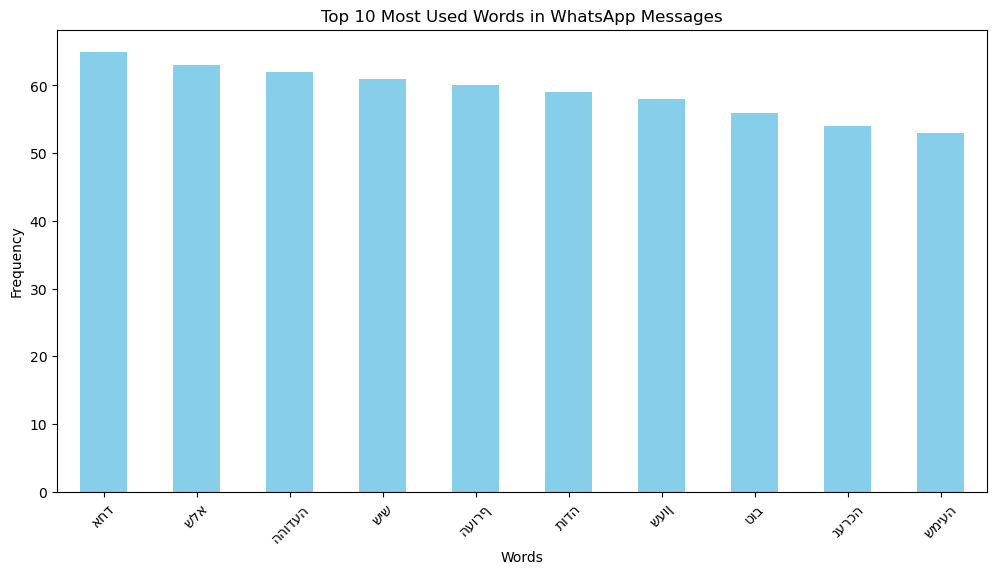

In [10]:


# Tokenize the messages into words
df_filtered['Tokenized_Message'] = df_filtered['Message'].apply(lambda x: re.findall(r'\b\w+\b', x))

# Convert the tokenized messages into strings
tokenized_messages_strings = df_filtered['Tokenized_Message_No_Stopwords'].apply(lambda x: ' '.join(x))

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer to the tokenized messages and transform them into a numerical matrix
X = vectorizer.fit_transform(tokenized_messages_strings)

# Convert the matrix to a DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the total count of each word
word_counts = bow_df.sum()

# Find the top 10 most used words
top_words = word_counts.nlargest(10)

# Plot the bar graph for the top 10 most used words
plt.figure(figsize=(12, 6))
top_words.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Words in WhatsApp Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

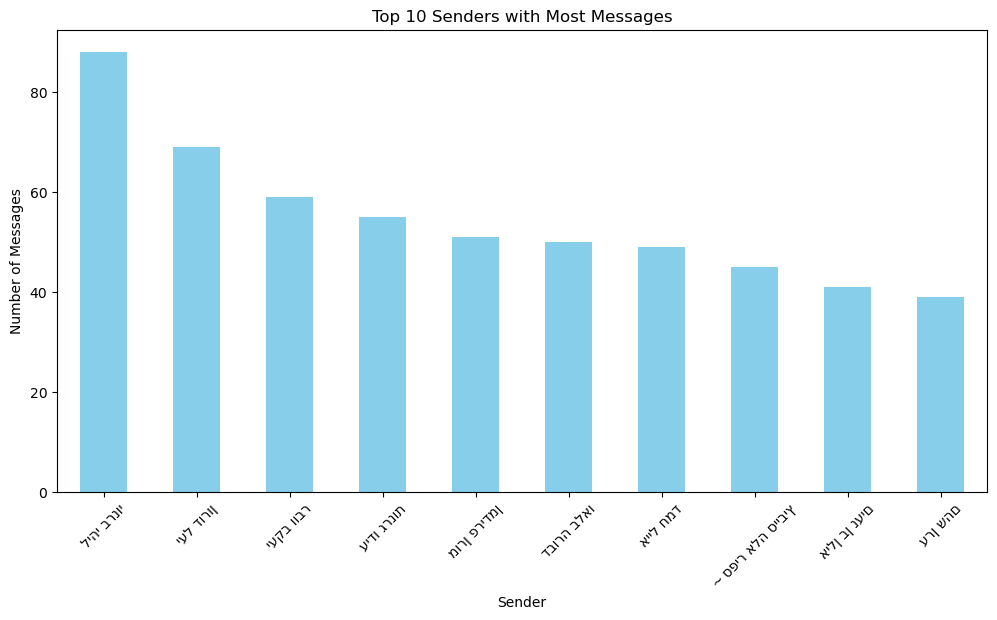

In [11]:
sender_message_counts = df_filtered['Sender'].value_counts()

# Find the top 10 senders with the most messages
top_senders = sender_message_counts.nlargest(10)

# Plot the bar graph for the top 10 senders
plt.figure(figsize=(12, 6))
top_senders.plot(kind='bar', color='skyblue')
plt.title('Top 10 Senders with Most Messages')
plt.xlabel('Sender')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\1924844346.py:1: UserWarning: Parsing dates in %d.%m.%Y, %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])


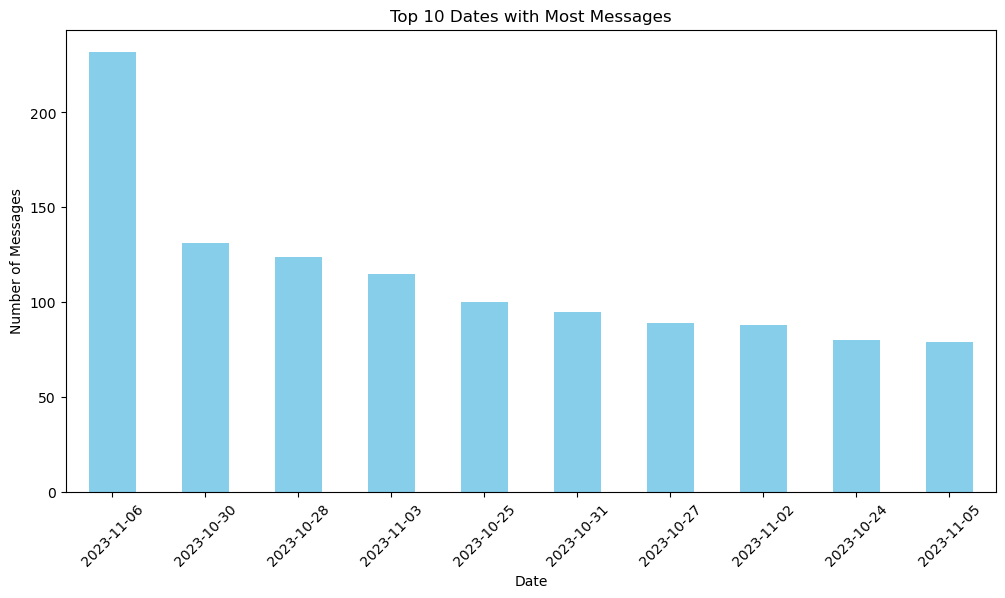

In [12]:
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])

# Extract the date from the timestamp and calculate the total count of messages for each date
date_message_counts = df_filtered['Timestamp'].dt.date.value_counts()

# Find the top 10 dates with the most messages
top_dates = date_message_counts.nlargest(10)

# Plot the bar graph for the top 10 dates
plt.figure(figsize=(12, 6))
top_dates.plot(kind='bar', color='skyblue')
plt.title('Top 10 Dates with Most Messages')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

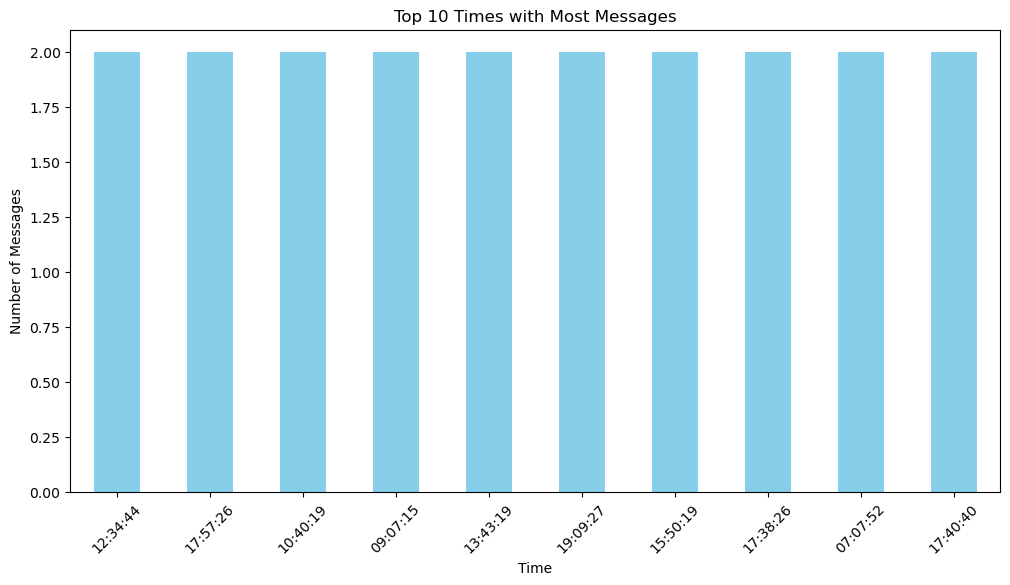

In [13]:
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])

# Extract the time from the timestamp and calculate the total count of messages for each time
time_message_counts = df_filtered['Timestamp'].dt.time.value_counts()

# Find the top 10 times with the most messages
top_times = time_message_counts.nlargest(10)

# Plot the bar graph for the top 10 times
plt.figure(figsize=(12, 6))
top_times.plot(kind='bar', color='skyblue')
plt.title('Top 10 Times with Most Messages')
plt.xlabel('Time')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.show()

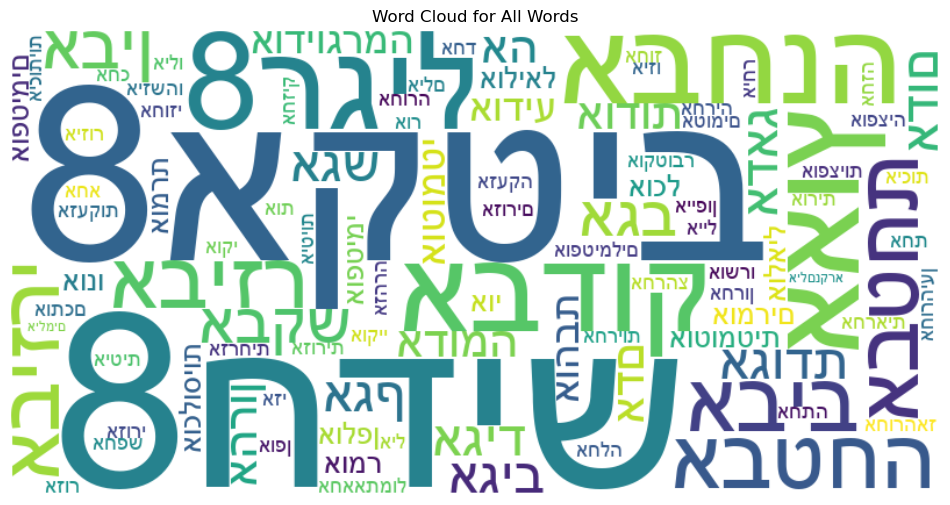

In [14]:

# Combine all messages into a single string
all_messages = ' '.join(bow_df)

# Create a WordCloud object for all words
wordcloud_all = WordCloud(width=800, height=400, background_color='white',
                          font_path='arial.ttf',  # Change to the appropriate system font
                          relative_scaling=0.5, max_words=100).generate(all_messages)

# Display the WordCloud for all words
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Words')
plt.show()


# 4. Topic modeling

C:\Users\97254\anaconda3.1\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\97254\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\97254\anaconda3.1\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecate

Number of Topics: 2, Coherence Score: 0.27198083690130526
Number of Topics: 3, Coherence Score: 0.3135593374962405
Number of Topics: 4, Coherence Score: 0.31755633979578124
Number of Topics: 5, Coherence Score: 0.29278795116004475
Number of Topics: 6, Coherence Score: 0.29555505046135405
Number of Topics: 7, Coherence Score: 0.3042370264683544
Number of Topics: 8, Coherence Score: 0.3229413897505531
Number of Topics: 9, Coherence Score: 0.34600463225426464
Number of Topics: 10, Coherence Score: 0.36186960382302263


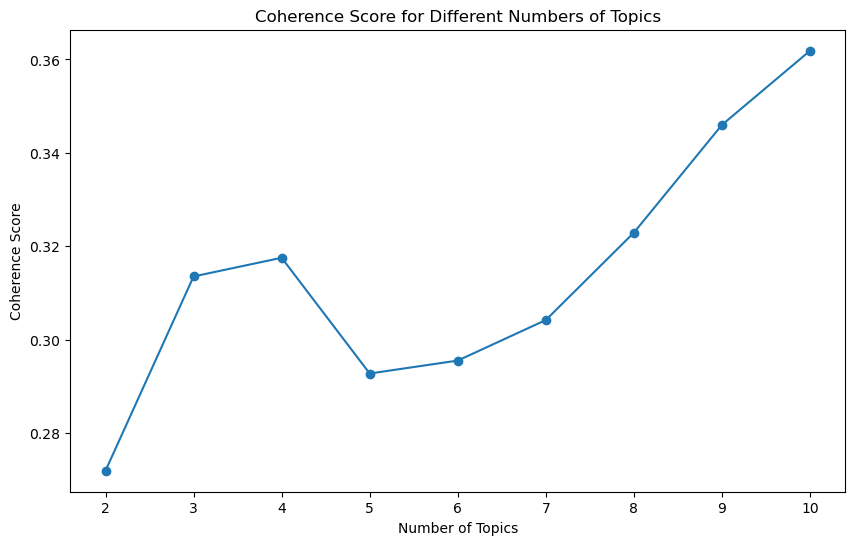

Optimal Number of Topics: 10


In [15]:
# Load the sentiment analysis pipeline for Hebrew
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Tokenize messages (assuming df_filtered['Tokenized_Message_No_Stopwords'] contains the original tokenized messages)
tokenized_messages = df_filtered['Tokenized_Message_No_Stopwords']

# Create a dictionary from the tokenized messages
dictionary = corpora.Dictionary(tokenized_messages)

# Create a corpus (bag of words) from the tokenized messages
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_messages]

# Define a range of potential numbers of topics
num_topics_range = range(2, 11)  # Adjust as needed

# Evaluate models for different numbers of topics
coherence_scores = []
for num_topics in num_topics_range:
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=2)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_messages, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

# Plot the coherence scores for different numbers of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Score for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score') 
plt.show()

optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal Number of Topics: {optimal_num_topics}")


In [16]:
# Retrain LDA model with the optimal number of topics
optimal_num_topics = optimal_num_topics
lda_model_optimal = gensim.models.LdaMulticore(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=2, workers=2)

# Display topics and associated terms
for topic_id in range(optimal_num_topics):
    terms = lda_model_optimal.show_topic(topic_id, topn=len(dictionary))
    top_terms = [term[0] for term in terms]
    print(f"\nTop terms for Topic {topic_id + 1} (Named Topic):")
    print(", ".join(top_terms))



Top terms for Topic 1 (Named Topic):
מאוד, שיש, לדעת, בכל, האם, אפשר, פעם, הרווחה, אזעקה, רטט, שלא, לעשות, צפירה, רוצים, חשוב, תודה, הטלפון, שמש, 8, אשמח, העורף, אזעקות, ניסיון, שעון, כדי, אחד, רגיל, ללא, כבר, כרית, שואלת, הכל, התראה, כמה, לקנות, הבעיה, חושב, ולא, בית, הכי, מכירים, הרבה, אחת, וגם, טוב, מתמחה, באמת, לגבי, לנייד, בוקר, יום, ממשלתי, משהו, פיקוד, להתממשק, לקבל, בתחום, רוצה, ה, משפטי, כשיש, האישי, שום, שמיעה, א, אנשים, שירות, היום, אפשרות, חדשות, תמיד, הרטט, בדיוק, שיהיה, אומר, קודם, כדאי, 2, תלוי, לך, שקט, הצבעות, ממקום, לדעתי, מאוחר, הזמן, גלאי, לנסות, בכי, חילקו, רואה, המערכת, חברה, רציתי, מזה, יודעים, נראה, באזור, תקווה, פתח, המידע, שלמים, וכו, נוספים, שתהיה, הגיוני, ברור, מקום, הצלחתי, מסל, בשמיעה, מניח, תקשורת, ההודעות, אזורים, החזר, משרד, מדבר, מטרה, בבנק, שהוא, הנגישות, קשר, מספיק, לבחור, לטלפון, ואחכ, יגיד, לאנשים, ירושלים, חודש, 7, שיחה, העירייה, מדהים, יעקב, אלפים, חירש, רווחה, מענה, סיוע, שבועיים, בזמן, עכשיו, בארץ, עוד, אדם, ווטסאפ, לקבוע, לכל, נציג, תור, אפלי

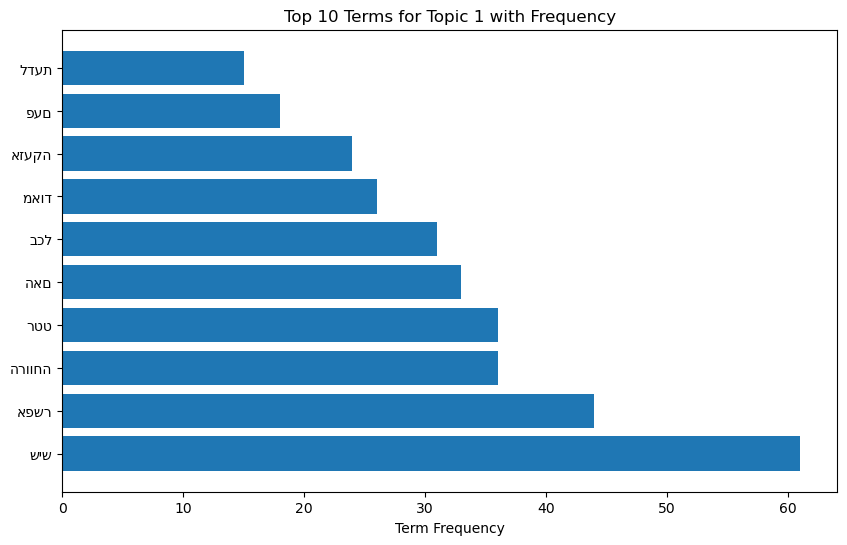

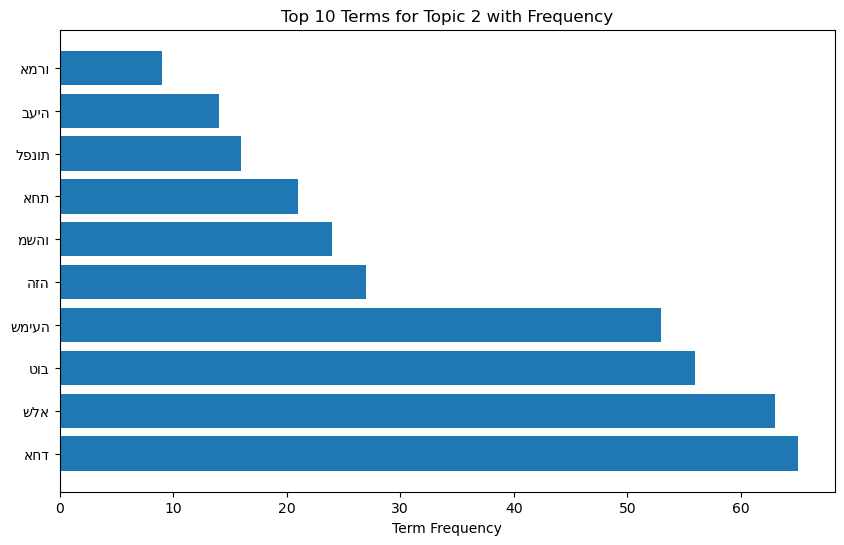

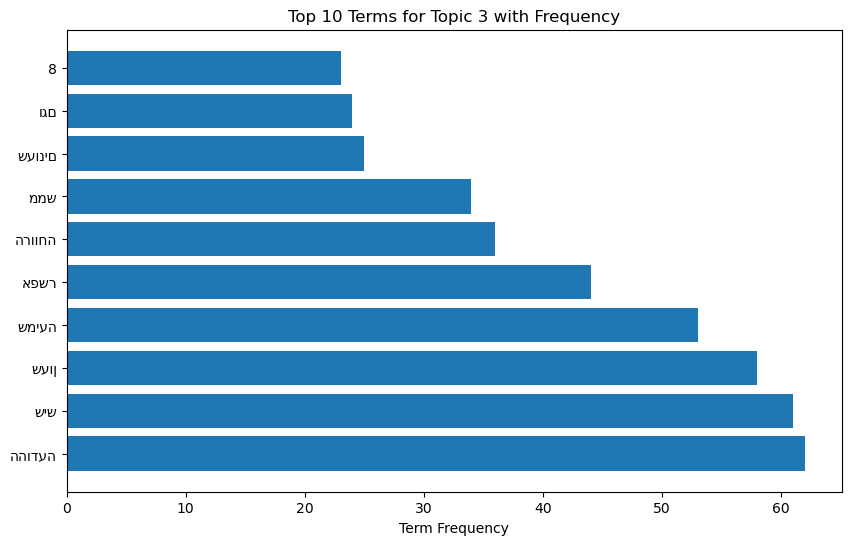

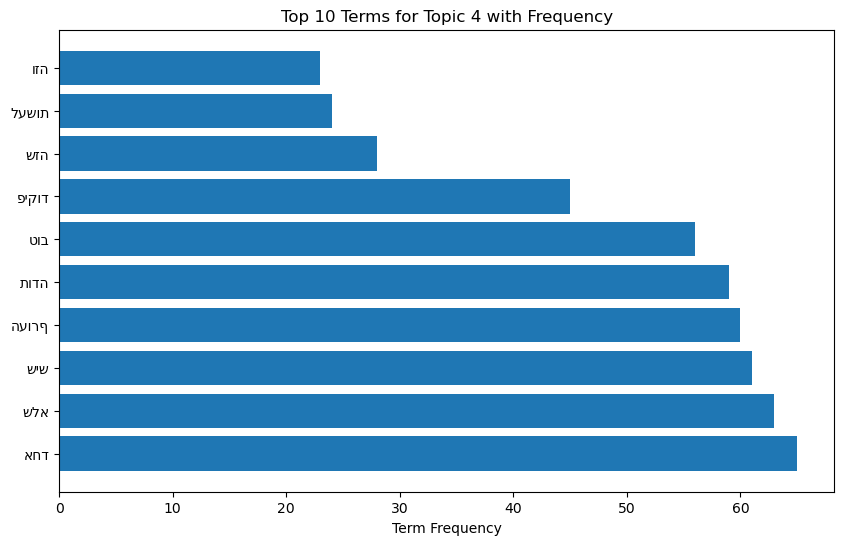

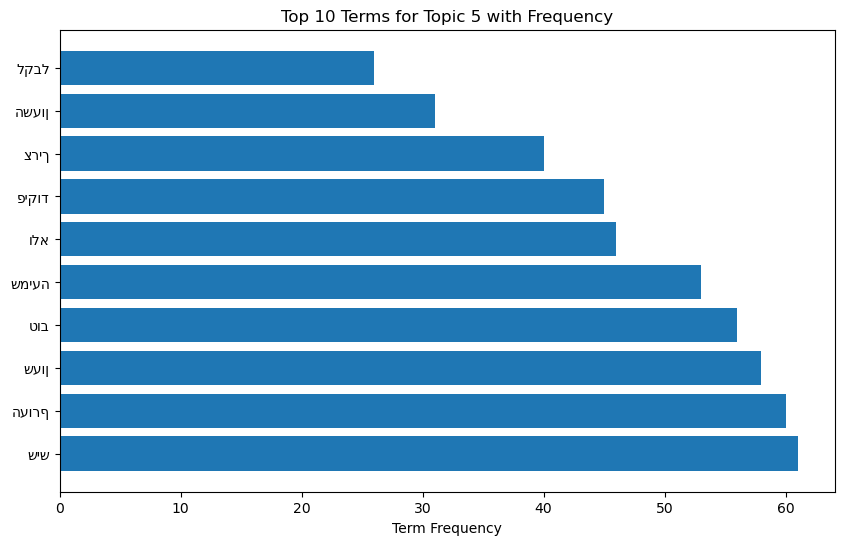

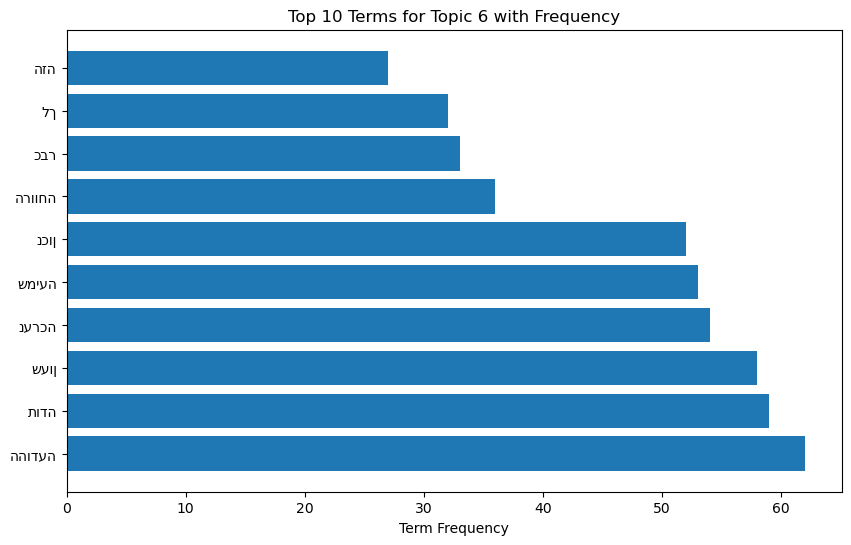

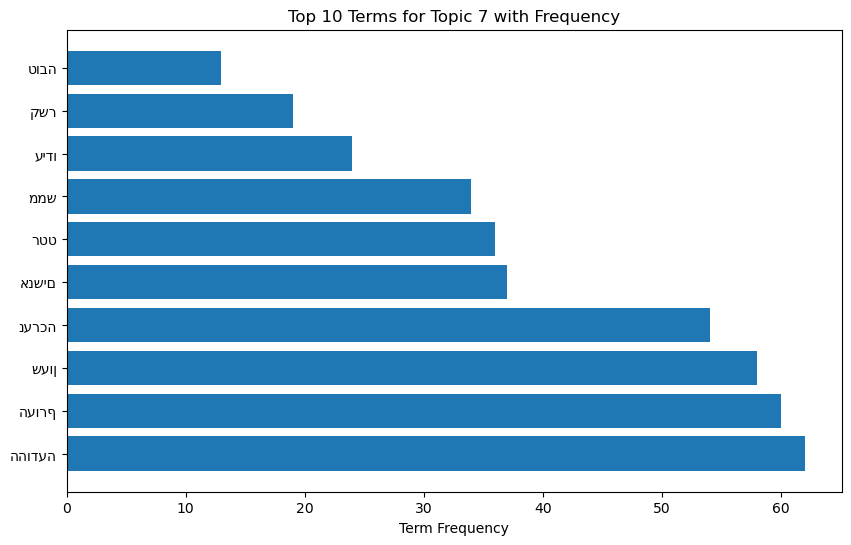

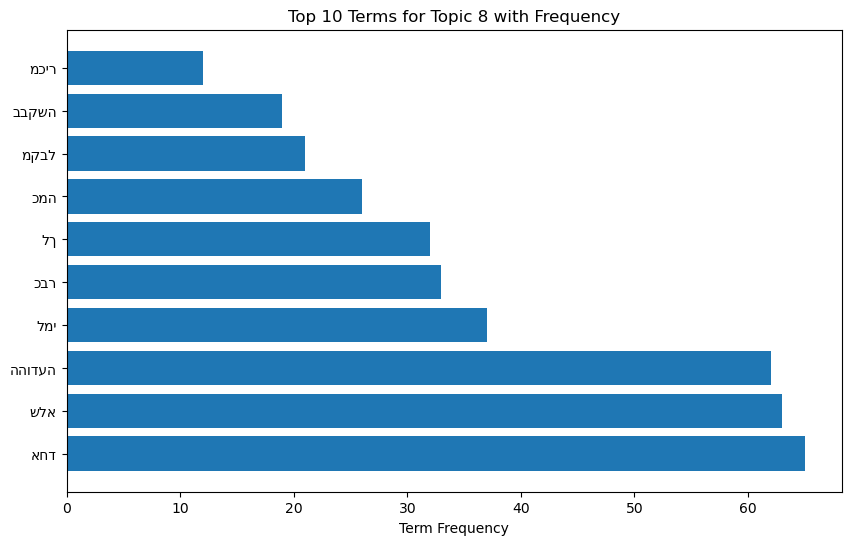

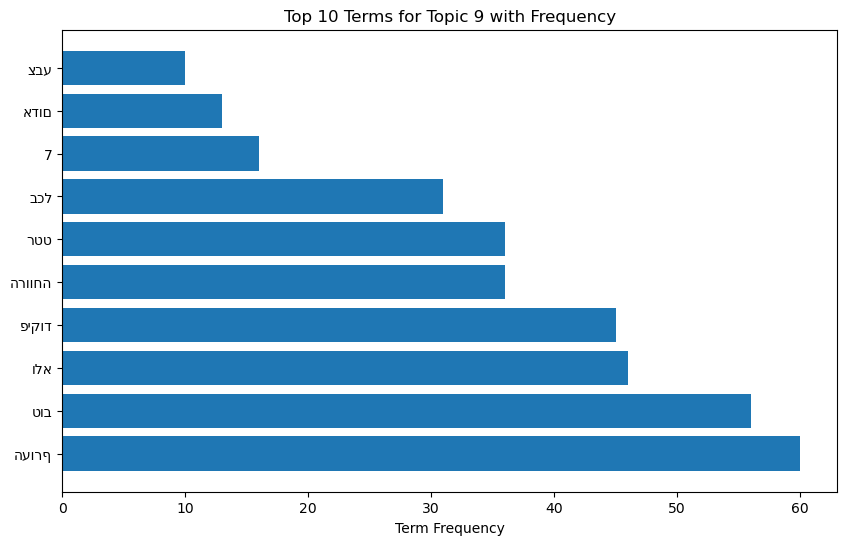

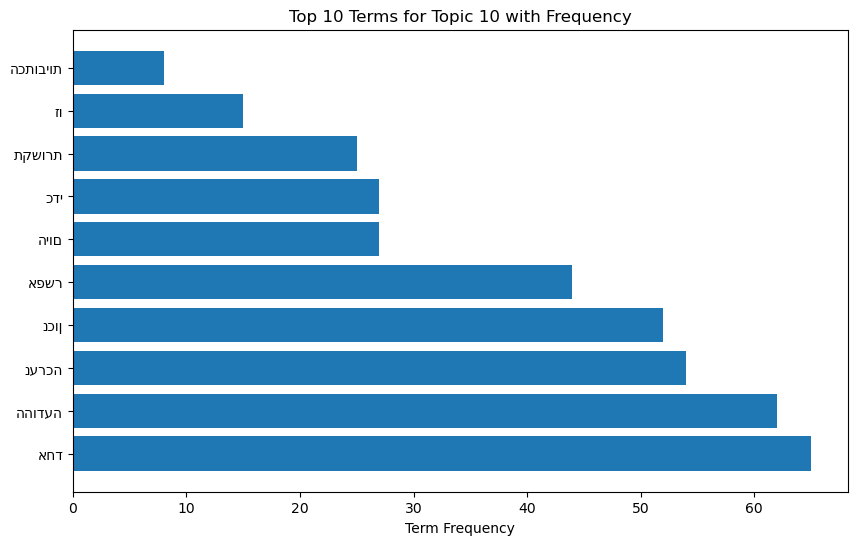

In [18]:
from collections import Counter


# Function to create a bar plot for the top terms in selected topics with term frequencies
def visualize_top_terms_with_frequency(lda_model, corpus, top_n=10):
    for topic_id in range(lda_model.num_topics):
        terms = lda_model.show_topic(topic_id, topn=top_n)

        # Flatten the list of terms from (term, probability) to just terms
        term_list = [term[0] for term in terms]

        # Count term frequencies in the entire corpus
        term_frequencies = Counter()
        for doc_bow in corpus:
            for term_id, term_freq in doc_bow:
                term = lda_model.id2word[term_id]
                if term in term_list:
                    term_frequencies[term] += term_freq

        # Sort terms by frequency
        sorted_terms = sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

        # Create a bar plot for the top terms with frequencies
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_terms)), [term[1] for term in sorted_terms], align='center')
        plt.yticks(range(len(sorted_terms)), [term[0] for term in sorted_terms])
        plt.xlabel('Term Frequency')
        plt.title(f'Top {top_n} Terms for Topic {topic_id + 1} with Frequency')
        plt.show()

# Visualize top 10 terms for each topic in the optimal model for all topics
visualize_top_terms_with_frequency(lda_model_optimal, corpus, top_n=10)


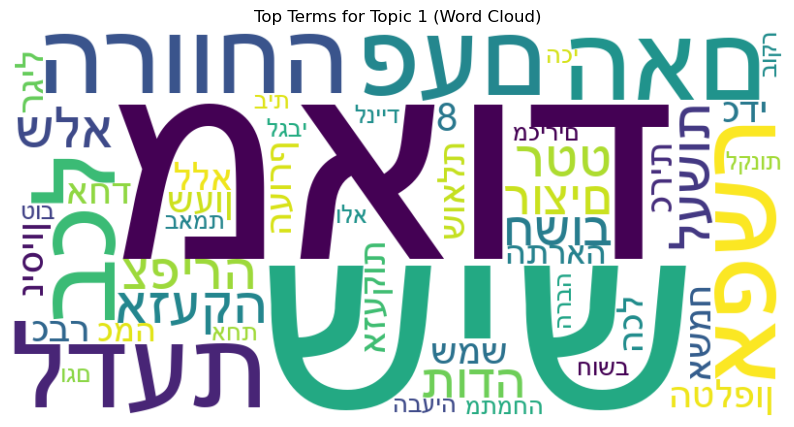

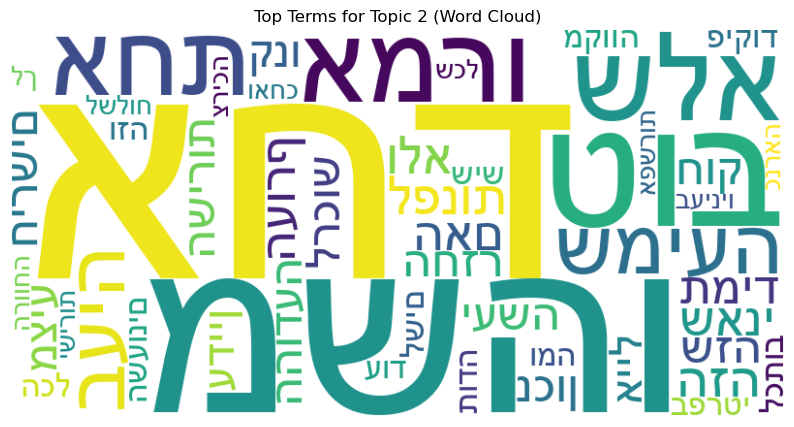

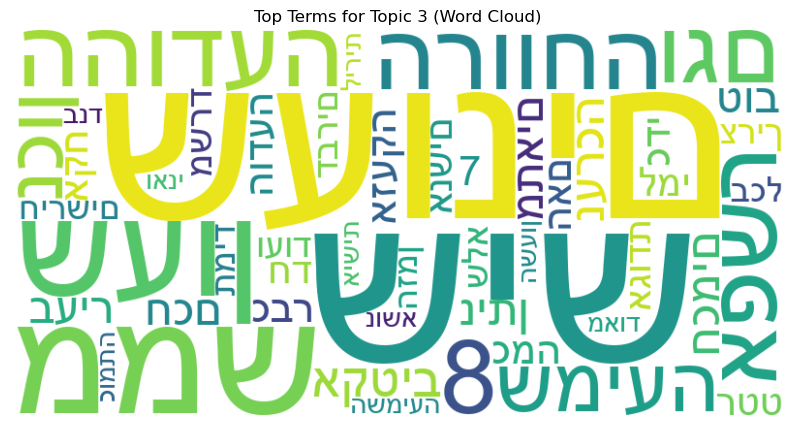

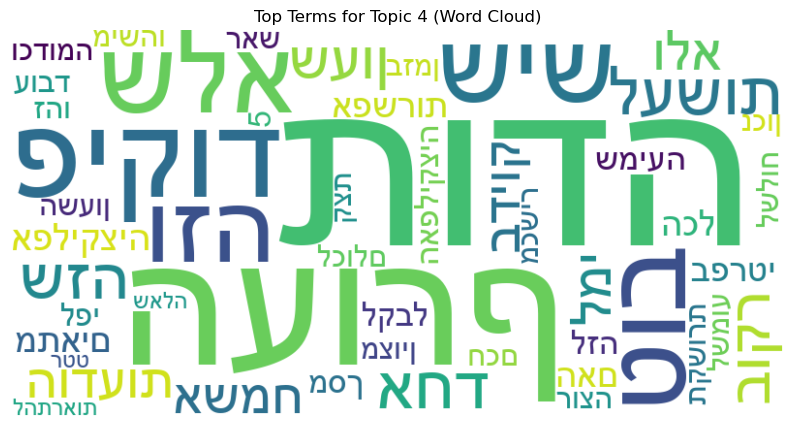

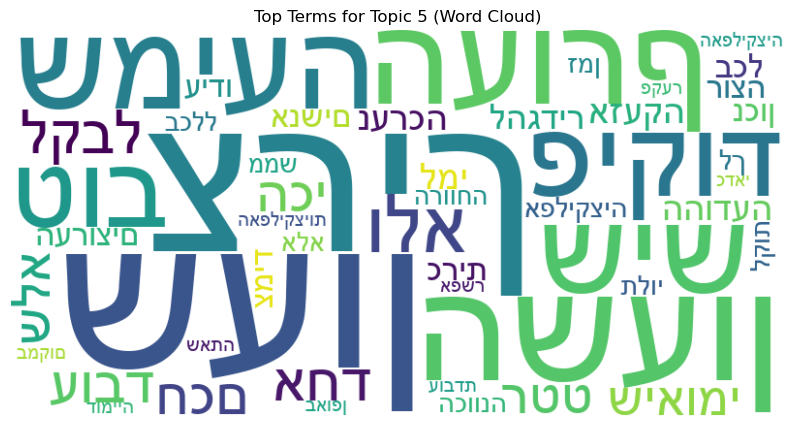

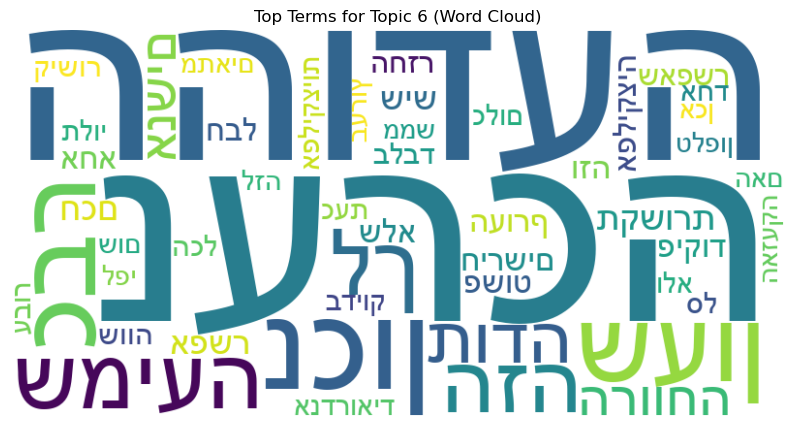

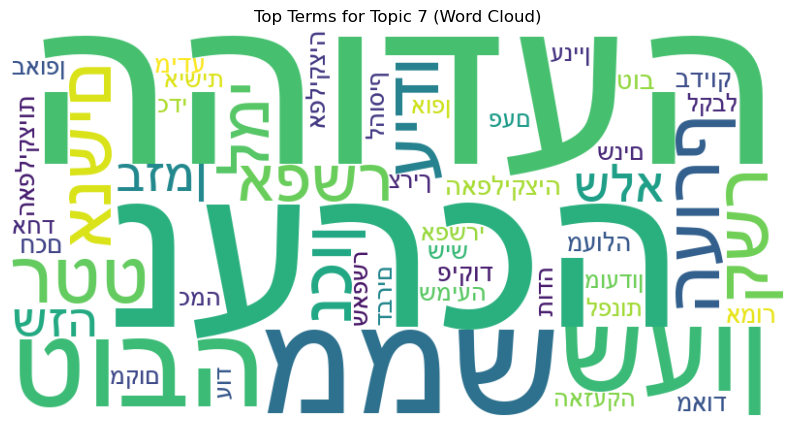

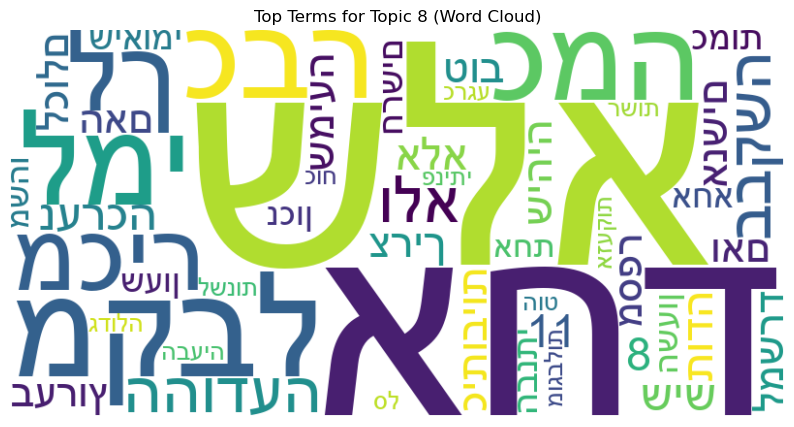

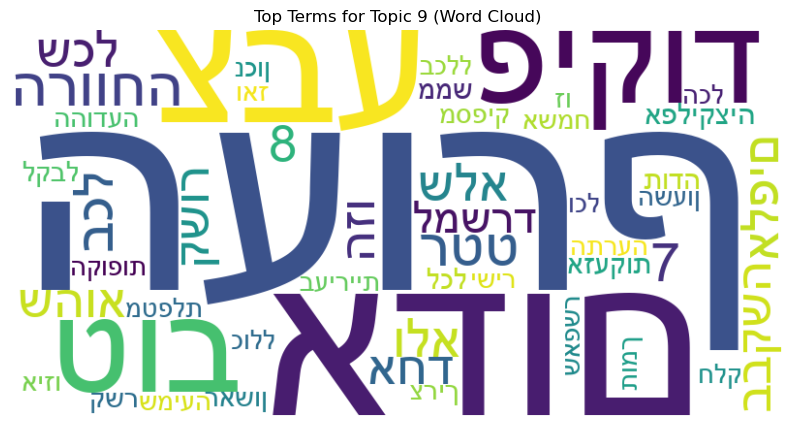

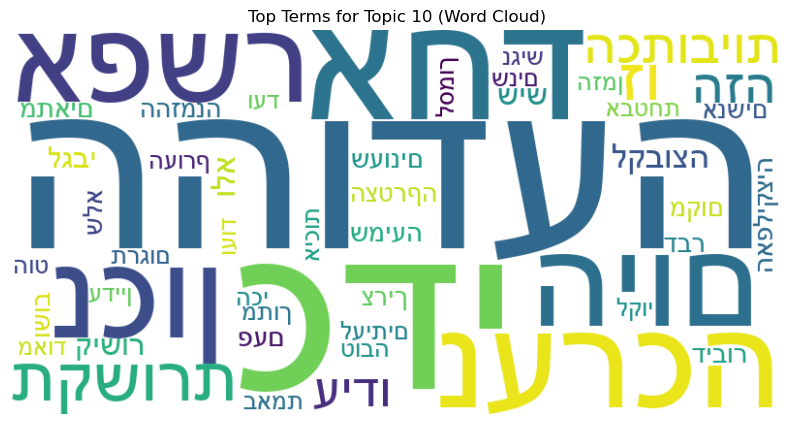

In [19]:

# Function to create word cloud for each topic with Hebrew text
def visualize_topics_wordcloud_hebrew(lda_model, num_topics):
    for topic_id in range(num_topics):
        terms = lda_model.show_topic(topic_id, topn=len(dictionary))
        top_terms = {term[0]: term[1] for term in terms}
        
        # Create a WordCloud object with RTL support
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              font_path='arial.ttf',  # Change to the appropriate system font
                              relative_scaling=0.5, max_words=50).generate_from_frequencies(top_terms)
        
        # Display the WordCloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Top Terms for Topic {topic_id + 1} (Word Cloud)')
        plt.show()

# Visualize topics using word clouds for the optimal model with 2 topics
visualize_topics_wordcloud_hebrew(lda_model_optimal, optimal_num_topics)


# 5.Sentiment analysis


In [20]:


# Load the sentiment analysis pipeline for Hebrew
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Create a list to store sentiment results
sentiment_results = []

# Iterate through each message in df_filtered
for index, row in df_filtered.iterrows():
    hebrew_text = row['Message']
    result = sentiment_analyzer(hebrew_text)
    sentiment_results.append(result[0]['label'])  # Append the sentiment label to the list

# Add the sentiment results to the df_filtered DataFrame
df_filtered['Sentiment'] = sentiment_results

# Display the updated DataFrame with sentiment column
df_filtered


Sender           Timestamp  \
0                רועי מרלי 2023-08-21 17:32:38   
1     יעל גורן (מפילדלפיה) 2023-10-08 22:22:51   
2                שחר דישבק 2023-10-23 09:56:43   
3             חזי לוי מהלב 2023-10-23 09:59:44   
4                שחר דישבק 2023-10-23 10:04:59   
...                    ...                 ...   
1301         דורית בן שלום 2023-11-07 11:40:51   
1302            רונן ברנוי 2023-11-07 11:41:06   
1303             יעקב וובר 2023-11-07 11:41:16   
1304              ~ Meitav 2023-11-07 12:00:33   
1305        לירית שפיר שמש 2023-11-07 13:11:19   

                                                Message  Line_Number  \
0     סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...            5   
1     האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...            9   
2     בוקר טוב אני רוצה לדווח לאחא וקיבלתי תשובה אוט...           18   
3     בוקר טוב . יחזקאל מהלב  האם יש משהו שנוכל לעזור ?           20   
4     אלא אם אתם מתעסקים בתמלולתרגום דרך אחא חוששתני...           21   
...                                                 ...          ...   
1301  מה שהצעתי . מי שבחרדות עקב המצב שירכוש שעון וי...         2727   
1302                         יאללה חמודיםות... יאללה...         2728   
1303             כמו שאמרתי אין השבע יודע את מצוקת הרעב         2729   
1304  כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...         2730   
1305  שלום לכולם כולנו בימים האלו רגישים והעצבים שלנ...         2739   

                                      Tokenized_Message  \
0     [סקר, חברת, שידורית, זכתה, במכרז, של, משרד, הר...   
1     [האם, יש, אפשרות, באפליקציה, לשנות, את, צליל, ...   
2     [בוקר, טוב, אני, רוצה, לדווח, לאחא, וקיבלתי, ת...   
3     [בוקר, טוב, יחזקאל, מהלב, האם, יש, משהו, שנוכל...   
4     [אלא, אם, אתם, מתעסקים, בתמלולתרגום, דרך, אחא,...   
...                                                 ...   
1301  [מה, שהצעתי, מי, שבחרדות, עקב, המצב, שירכוש, ש...   
1302                           [יאללה, חמודיםות, יאללה]   
1303    [כמו, שאמרתי, אין, השבע, יודע, את, מצוקת, הרעב]   
1304  [כי, היא, חכמה, גדולה, והבנה, שלה, מושלמת, והב...   
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...   

                         Tokenized_Message_No_Stopwords Sentiment  
0     [סקר, חברת, שידורית, זכתה, במכרז, משרד, הרווחה...    1 star  
1     [האם, אפשרות, באפליקציה, לשנות, צליל, ההתראה, ...   2 stars  
2     [בוקר, טוב, רוצה, לדווח, לאחא, וקיבלתי, תשובה,...   4 stars  
3     [בוקר, טוב, יחזקאל, מהלב, האם, משהו, שנוכל, לע...   3 stars  
4        [אלא, מתעסקים, בתמלולתרגום, אחא, חוששתני, שלא]   2 stars  
...                                                 ...       ...  
1301  [שהצעתי, שבחרדות, עקב, המצב, שירכוש, שעון, ויז...   5 stars  
1302                           [יאללה, חמודיםות, יאללה]    1 star  
1303                  [שאמרתי, השבע, יודע, מצוקת, הרעב]   5 stars  
1304   [חכמה, גדולה, והבנה, מושלמת, והבנה, לוקה, בחוסר]   2 stars  
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...   4 stars  

[1306 rows x 7 columns]

### 1 star - very negative

### 2 stars - negative

### 3 stars - neutral

### 4 stars - positive

### 5 stars - very positive

In [21]:

# Select messages with "1 star" in the 'Sentiment' column from df_filtered
messages_with_1_stars = df_filtered[df_filtered['Sentiment'] == '1 star'].head(10)

# Display the selected messages
print("Messages with 1 stars:")
print(messages_with_1_stars[['Message', 'Sentiment']])


Messages with 1 stars:
                                              Message Sentiment
0   סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...    1 star
5           מה הקישור לקבוצה חפירות כוח? ההודעה נערכה    1 star
9   אשמח לתזכורת... איך אני מגישה בקשה להחזר סל תק...    1 star
10      רכישת מכשירי שמיעה? זה לא במסגרת קופת החולים?    1 star
16         או שתשבי מול הטלויזיה יש שם כל הזמן התראות    1 star
17  אבקש בכל לשון של בקשה  זה לא קשור לנושא של כבד...    1 star
19              מתנצלת מחקתי. רציתי רק לנסות לעודד...    1 star
20  כל מי שרוצה לכתוב לספיר אני מציע לשלוח לה בפרט...    1 star
23                         לא מוצאת את הטלפון של ספיר    1 star
26                                               אני?    1 star


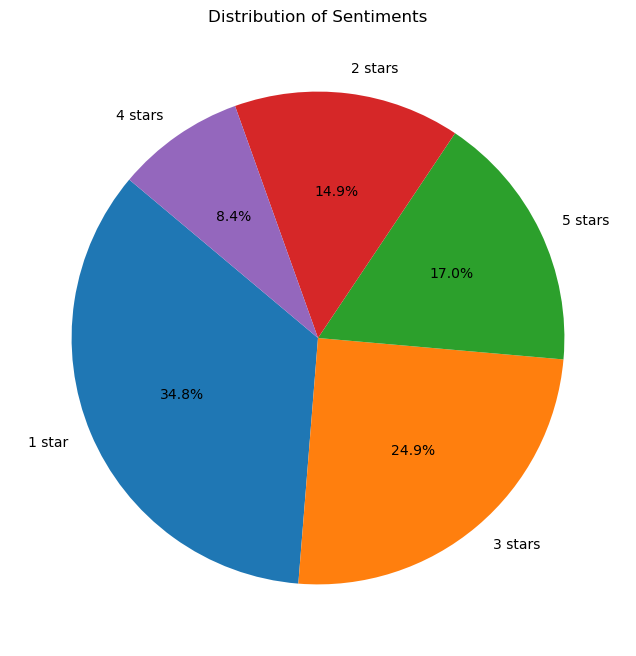

In [22]:

# Count the occurrences of each sentiment label in the 'Sentiment' column
sentiment_counts = df_filtered['Sentiment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.show()


### we can see that the group chat is mostly negative 


# 6.Explanations : 

### First, we downloaded the file, and then we uploaded it.






### Subsequently, we organized the messages into rows, and we ended up with 1566 rows.






### And then we performed cleaning and organization for the data.






### In the next stage, we conducted Exploratory Data Analysis (EDA) on the existing data, generated various graphs, and created a Word Cloud based on the existing data.

### At this stage, we discovered which word is most frequently used by group participants, identified the most active member in the group, and determined on which dates and at what times the group is most active.

### Subsequently, we performed Topic Modeling on the data. At this stage, we examined how many topics we could identify in the data, what words are associated with each topic, identified the top 10 words that appear most frequently in each topic, and created a Word Cloud for each topic.

### Finally, we conducted Sentiment Analysis to assess the sentiment of the group's messages. The rating was done using stars, where one star represents very negative sentiment and five stars represent very positive sentiment. Through these data, we found that the overall sentiment of the group tends to be more negative than positive most of the time.

# 7. Extras

In [23]:
import pandas as pd
from collections import Counter

# Assuming df_filtered is already defined in your code

# Convert 'Timestamp' to datetime
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])

# Extract the date from the timestamp
df_filtered['Date'] = df_filtered['Timestamp'].dt.date

# Calculate the total count of messages for each date
date_message_counts = df_filtered['Date'].value_counts()

# Find the top 10 dates with the most messages
top_dates = date_message_counts.nlargest(10).index

# Create an empty dictionary to store words for each date
date_words_dict = {}

# Iterate through each top date
for date in top_dates:
    # Extract the tokenized messages for the current date
    date_tokens = df_filtered[df_filtered['Date'] == date]['Tokenized_Message']
    
    # Combine tokenized messages into a single list
    all_tokens = [token for tokens_list in date_tokens for token in tokens_list]
    
    # Count occurrences of each word
    word_counts = Counter(all_tokens)
    
    # Get the top 15 words
    top_words = [word for word, count in word_counts.most_common(15)]
    
    # Store the top words in the dictionary
    date_words_dict[date] = top_words

# Print date and top 15 words for each top date
for date, top_words in date_words_dict.items():
    print(f'Date: {date}')
    print(f'Top 15 Words: {", ".join(top_words)}\n')


Date: 2023-11-06
Top 15 Words: לא, זה, מה, את, של, אני, אז, על, לי, הרווחה, אם, גם, יש, 8, תודה

Date: 2023-10-30
Top 15 Words: לא, זה, על, אני, את, מה, של, אין, לי, מי, אם, עידו, יש, או, ההודעה

Date: 2023-10-28
Top 15 Words: לא, זה, את, של, שמיעה, על, מה, גם, אני, אבל, יש, כל, אין, אז, או

Date: 2023-11-03
Top 15 Words: לא, כל, זה, אני, את, יש, אחד, גם, מי, מקבל, של, על, מה, אז, חירשים

Date: 2023-10-25
Top 15 Words: לא, זה, של, על, יש, את, כל, מה, גם, רק, אם, אני, שיש, או, השעון

Date: 2023-10-31
Top 15 Words: לא, זה, יש, על, אם, עם, אני, גם, של, או, אז, העורף, את, פיקוד, רק

Date: 2023-10-27
Top 15 Words: לא, זה, את, על, של, גם, מה, כל, יש, נכון, העורף, האפליקציה, אין, רק, שיש

Date: 2023-11-02
Top 15 Words: לא, את, יש, של, זה, אין, עם, גם, אני, הוט, על, אם, דרך, תודה, לי

Date: 2023-10-24
Top 15 Words: לא, זה, גם, יש, טוב, מה, שעון, עם, על, אני, לי, צריך, את, רטט, של

Date: 2023-11-05
Top 15 Words: זה, לא, יש, אני, של, גם, את, על, תודה, או, בית, לי, העורף, רטט, ההודעה



In [24]:
import pandas as pd
from collections import Counter

# Assuming df_filtered is already defined in your code

# Convert 'Timestamp' to datetime
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])

# Extract the date from the timestamp
df_filtered['Date'] = df_filtered['Timestamp'].dt.date

# Calculate the total count of messages for each date
date_message_counts = df_filtered['Date'].value_counts()

# Find the top 10 dates with the most messages
top_dates = date_message_counts.nlargest(10).index

# Create an empty dictionary to store the count of 'אזעקה' for each date
word_count_dict = {}

# Iterate through each top date
for date in top_dates:
    # Extract the tokenized messages for the current date
    date_tokens = df_filtered[df_filtered['Date'] == date]['Tokenized_Message']
    
    # Combine tokenized messages into a single list
    all_tokens = [token for tokens_list in date_tokens for token in tokens_list]
    
    # Count occurrences of 'אזעקה'
    word_count = all_tokens.count('אזעקה')
    
    # Store the count in the dictionary
    word_count_dict[date] = word_count

# Print date and count of 'אזעקה' for each top date
for date, count in word_count_dict.items():
    print(f'Date: {date}')
    print(f'Count of אזעקה: {count}\n')


Date: 2023-11-06
Count of אזעקה: 3

Date: 2023-10-30
Count of אזעקה: 4

Date: 2023-10-28
Count of אזעקה: 1

Date: 2023-11-03
Count of אזעקה: 2

Date: 2023-10-25
Count of אזעקה: 5

Date: 2023-10-31
Count of אזעקה: 2

Date: 2023-10-27
Count of אזעקה: 1

Date: 2023-11-02
Count of אזעקה: 1

Date: 2023-10-24
Count of אזעקה: 2

Date: 2023-11-05
Count of אזעקה: 2



In [25]:
# Assuming df_filtered is already defined in your code

# Convert 'Timestamp' to datetime
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'])

# Extract the date from the timestamp
df_filtered['Date'] = df_filtered['Timestamp'].dt.date

# Calculate the total count of messages for each date
date_message_counts = df_filtered['Date'].value_counts()

# Find the top 10 dates with the most messages
top_dates = date_message_counts.nlargest(10).index

# Print messages for each top date
for date in top_dates:
    print(f'Messages for Date: {date}')
    messages_for_date = df_filtered[df_filtered['Date'] == date]['Message']
    for message in messages_for_date:
        print(f'- {message}')
    print('\n' + '-'*50 + '\n')


Messages for Date: 2023-11-06
- יש בקבוצה אנשים שקיבלו את הדגם. האם הרטט באמת חלש???
- ניסיתי אקטיב 8 וגם את הרגילים 7 ו8. אקטיב מאד חלש. ה2 האחרים מעולים.
- תודה... השניים האחרים אם כך יותר פשוטים מהאקטיב???
- מאיזה עיר את?
- לא תמיד מה שהכי מתקדם הוא כנראה הכי טוב...
- 8 רגיל יותר מתקדם מאקטיב
- וכמה הוא עולה???
- האם רטט שלו חזק שמעיר בלילה?
- בוקר טוב.  זה לא הכי קשור בשמיעה אבל אולי חלקכם משתמש בפייסבוק לצרכים שונים שקשורים בשמיעה ולכן מעדכן  כשנכנסים לאלפיקציההכפתור של אחורהיען כדי לחזור אחורהאז אי אפשר.  פייסבוק ביטל את זה.  יהיה לכם חץ בחלק העליון או התחתון של המסךמימין.  לחיצה עליו תחזיר אתכם אחורה
- המשך יום טוב לכולם
- לבדוק במלאי בסניפים
- לעניות דעתי השעון צריך להיות על ידך כדי שתרגישי את הרטט. נכון???
- אני שואלת בעלי נסיון אם התעוררו משינה מהרטט?
- שאלה חשובה גם שואלת אותה הדבר
- מצטרפת לשאלה
- שאלה עקרונית  למי שיש שעון אייפון האם צריך שעון חכם אחר ?
- לא  יש שתי אפליקציות לאייפון להתראות צבע אדום  אפליקציות  הללו מספיק לקבל התראות בכל מצבי ריכוז גם אם תיצרי מצב ריכוז ח

### בדקנו בתאריכים שהייתה בהם הכי הרבה פעילות את המילים שחוזרות על עצמן הכי הרבה , בנוסף בדקנו האם הייתה תנועה בקבוצה בעקבות אזעקות ולבסוף הדפסנו את ההודעות על מנת לראות האם באמת היו אזעקות בימים אלו.

In [26]:
import pandas as pd

# Assuming you have already loaded your dataframe as df_filtered

# Convert 'Timestamp' column to datetime format
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'], format='%d.%m.%Y, %H:%M:%S')

# Create 'Date' and 'Time' columns
df_filtered['Date'] = df_filtered['Timestamp'].dt.date
df_filtered['Time'] = df_filtered['Timestamp'].dt.time

# Display the updated DataFrame
df_filtered[['Timestamp', 'Date', 'Time']]


Timestamp        Date      Time
0    2023-08-21 17:32:38  2023-08-21  17:32:38
1    2023-10-08 22:22:51  2023-10-08  22:22:51
2    2023-10-23 09:56:43  2023-10-23  09:56:43
3    2023-10-23 09:59:44  2023-10-23  09:59:44
4    2023-10-23 10:04:59  2023-10-23  10:04:59
...                  ...         ...       ...
1301 2023-11-07 11:40:51  2023-11-07  11:40:51
1302 2023-11-07 11:41:06  2023-11-07  11:41:06
1303 2023-11-07 11:41:16  2023-11-07  11:41:16
1304 2023-11-07 12:00:33  2023-11-07  12:00:33
1305 2023-11-07 13:11:19  2023-11-07  13:11:19

[1306 rows x 3 columns]

In [27]:
import pandas as pd

# Assuming you have already loaded your dataframe as df_filtered

# Convert 'Timestamp' column to datetime format
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'], format='%Y-%m-%d %H:%M:%S')

# Create new columns for Year, Month, Day, and Time
df_filtered['Year'] = df_filtered['Timestamp'].dt.year
df_filtered['Month'] = df_filtered['Timestamp'].dt.month
df_filtered['Day'] = df_filtered['Timestamp'].dt.day
df_filtered['Time'] = df_filtered['Timestamp'].dt.time

# Display the updated DataFrame
df_filtered


Sender           Timestamp  \
0                רועי מרלי 2023-08-21 17:32:38   
1     יעל גורן (מפילדלפיה) 2023-10-08 22:22:51   
2                שחר דישבק 2023-10-23 09:56:43   
3             חזי לוי מהלב 2023-10-23 09:59:44   
4                שחר דישבק 2023-10-23 10:04:59   
...                    ...                 ...   
1301         דורית בן שלום 2023-11-07 11:40:51   
1302            רונן ברנוי 2023-11-07 11:41:06   
1303             יעקב וובר 2023-11-07 11:41:16   
1304              ~ Meitav 2023-11-07 12:00:33   
1305        לירית שפיר שמש 2023-11-07 13:11:19   

                                                Message  Line_Number  \
0     סקר חברת שידורית זכתה במכרז של משרד הרווחה לאס...            5   
1     האם יש אפשרות באפליקציה לשנות את צליל ההתראה מ...            9   
2     בוקר טוב אני רוצה לדווח לאחא וקיבלתי תשובה אוט...           18   
3     בוקר טוב . יחזקאל מהלב  האם יש משהו שנוכל לעזור ?           20   
4     אלא אם אתם מתעסקים בתמלולתרגום דרך אחא חוששתני...           21   
...                                                 ...          ...   
1301  מה שהצעתי . מי שבחרדות עקב המצב שירכוש שעון וי...         2727   
1302                         יאללה חמודיםות... יאללה...         2728   
1303             כמו שאמרתי אין השבע יודע את מצוקת הרעב         2729   
1304  כי היא חכמה גדולה והבנה שלה מושלמת והבנה שלנו ...         2730   
1305  שלום לכולם כולנו בימים האלו רגישים והעצבים שלנ...         2739   

                                      Tokenized_Message  \
0     [סקר, חברת, שידורית, זכתה, במכרז, של, משרד, הר...   
1     [האם, יש, אפשרות, באפליקציה, לשנות, את, צליל, ...   
2     [בוקר, טוב, אני, רוצה, לדווח, לאחא, וקיבלתי, ת...   
3     [בוקר, טוב, יחזקאל, מהלב, האם, יש, משהו, שנוכל...   
4     [אלא, אם, אתם, מתעסקים, בתמלולתרגום, דרך, אחא,...   
...                                                 ...   
1301  [מה, שהצעתי, מי, שבחרדות, עקב, המצב, שירכוש, ש...   
1302                           [יאללה, חמודיםות, יאללה]   
1303    [כמו, שאמרתי, אין, השבע, יודע, את, מצוקת, הרעב]   
1304  [כי, היא, חכמה, גדולה, והבנה, שלה, מושלמת, והב...   
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...   

                         Tokenized_Message_No_Stopwords Sentiment        Date  \
0     [סקר, חברת, שידורית, זכתה, במכרז, משרד, הרווחה...    1 star  2023-08-21   
1     [האם, אפשרות, באפליקציה, לשנות, צליל, ההתראה, ...   2 stars  2023-10-08   
2     [בוקר, טוב, רוצה, לדווח, לאחא, וקיבלתי, תשובה,...   4 stars  2023-10-23   
3     [בוקר, טוב, יחזקאל, מהלב, האם, משהו, שנוכל, לע...   3 stars  2023-10-23   
4        [אלא, מתעסקים, בתמלולתרגום, אחא, חוששתני, שלא]   2 stars  2023-10-23   
...                                                 ...       ...         ...   
1301  [שהצעתי, שבחרדות, עקב, המצב, שירכוש, שעון, ויז...   5 stars  2023-11-07   
1302                           [יאללה, חמודיםות, יאללה]    1 star  2023-11-07   
1303                  [שאמרתי, השבע, יודע, מצוקת, הרעב]   5 stars  2023-11-07   
1304   [חכמה, גדולה, והבנה, מושלמת, והבנה, לוקה, בחוסר]   2 stars  2023-11-07   
1305  [שלום, לכולם, כולנו, בימים, האלו, רגישים, והעצ...   4 stars  2023-11-07   

          Time  Year  Month  Day  
0     17:32:38  2023      8   21  
1     22:22:51  2023     10    8  
2     09:56:43  2023     10   23  
3     09:59:44  2023     10   23  
4     10:04:59  2023     10   23  
...        ...   ...    ...  ...  
1301  11:40:51  2023     11    7  
1302  11:41:06  2023     11    7  
1303  11:41:16  2023     11    7  
1304  12:00:33  2023     11    7  
1305  13:11:19  2023     11    7  

[1306 rows x 12 columns]

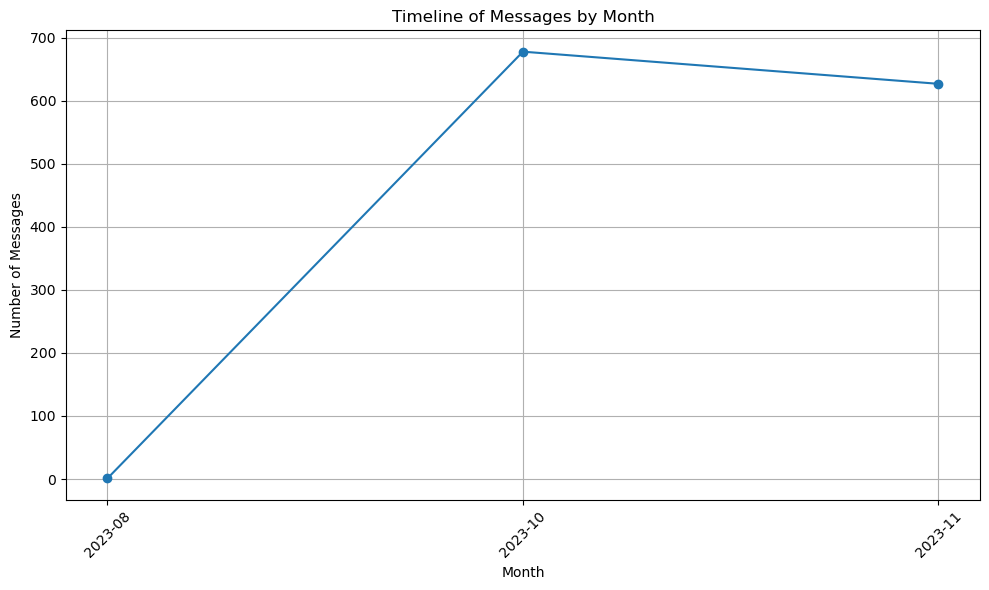

In [28]:
import matplotlib.pyplot as plt

# Group the data by Month and count the number of messages in each month
monthly_counts = df_filtered.groupby(['Year', 'Month']).size().reset_index(name='Message Count')

# Plot the timeline graph
plt.figure(figsize=(10, 6))
plt.plot(monthly_counts.index, monthly_counts['Message Count'], marker='o', linestyle='-')
plt.title('Timeline of Messages by Month')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(ticks=monthly_counts.index, labels=monthly_counts.apply(lambda x: f"{x['Year']}-{x['Month']:02d}", axis=1), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


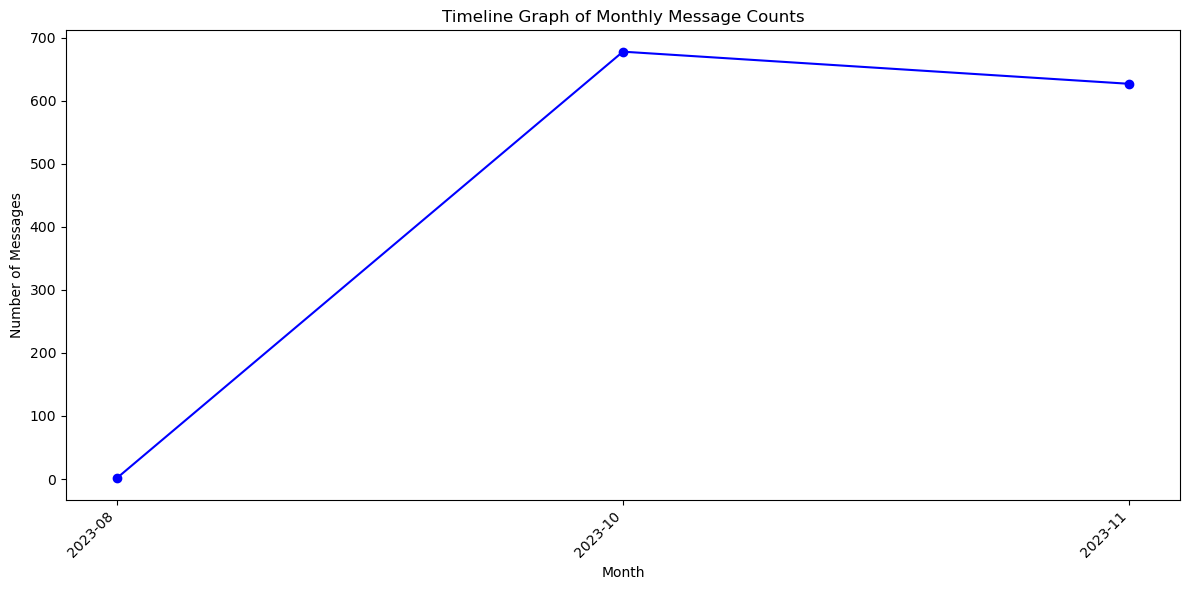

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataframe as df_filtered

# Convert 'Date' column to datetime format if it's not already
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Extract unique months from the 'Date' column
unique_months = df_filtered['Date'].dt.to_period('M').unique()

# Group by month and count the number of messages for each month
monthly_message_counts = df_filtered.groupby(df_filtered['Date'].dt.to_period('M')).size()

# Create a timeline graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_message_counts.index.astype(str), monthly_message_counts, marker='o', linestyle='-', color='b')
plt.title('Timeline Graph of Monthly Message Counts')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')

# Show only unique months
plt.xticks([str(month) for month in unique_months])

plt.tight_layout()
plt.show()


## ניתן לראות כי הייתה קפיצה ניכרת בפעילות הקבוצה בחודש שהתחילה המלחמה

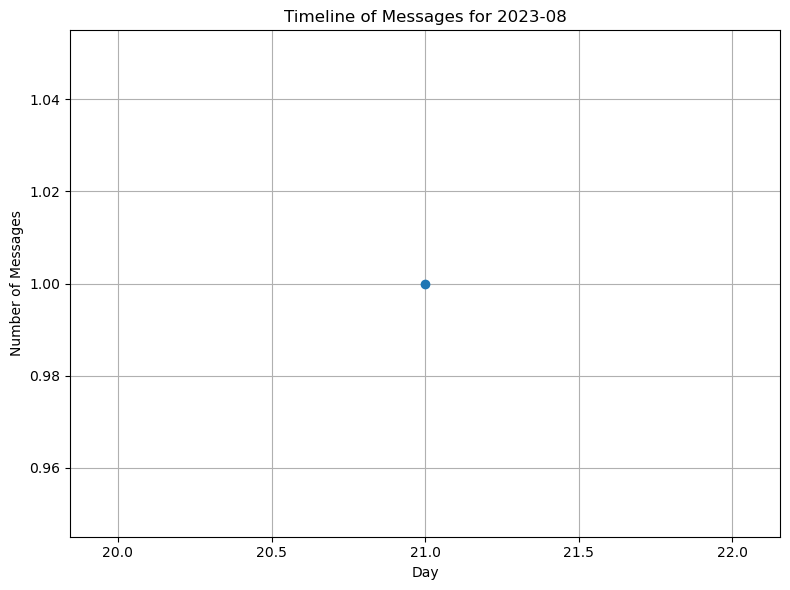

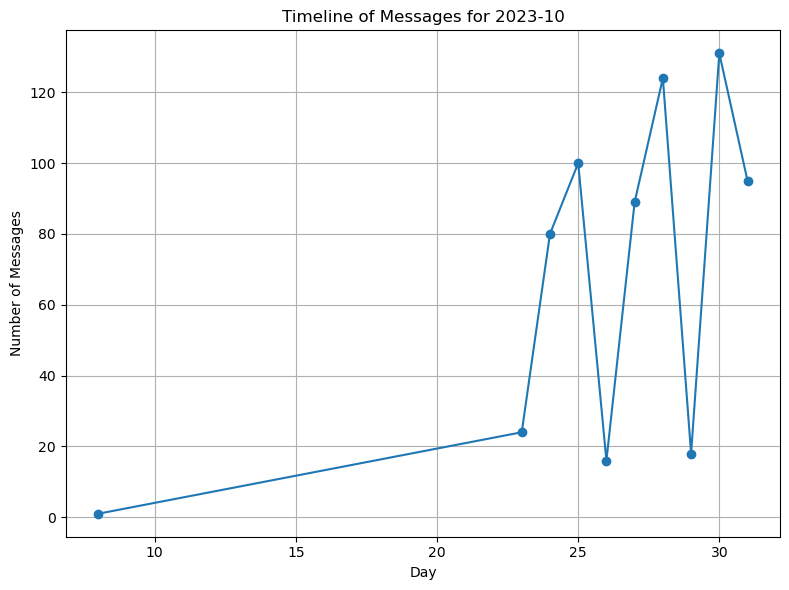

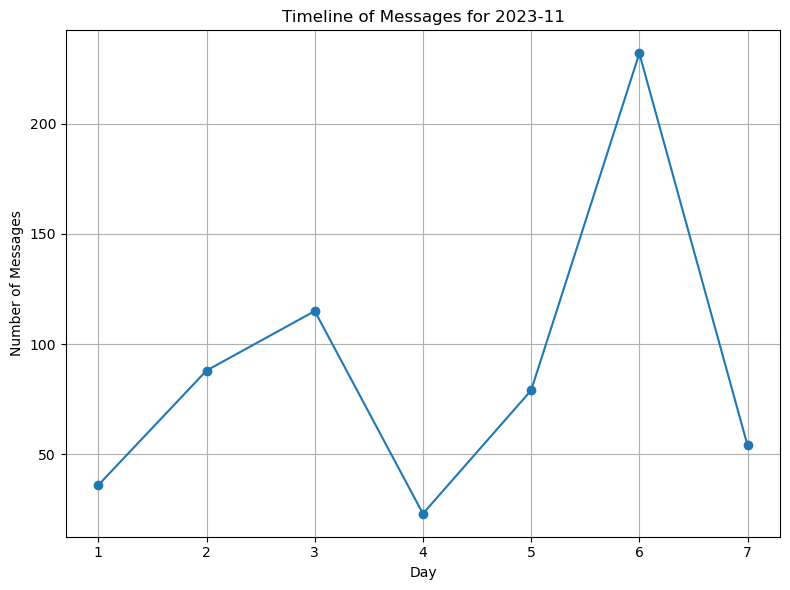

In [31]:
import matplotlib.pyplot as plt

# Group the data by Year and Month and count the number of messages in each month
monthly_counts = df_filtered.groupby(['Year', 'Month']).size().reset_index(name='Message Count')

# Iterate over each month and plot the timeline
for index, row in monthly_counts.iterrows():
    year = row['Year']
    month = row['Month']
    month_data = df_filtered[(df_filtered['Year'] == year) & (df_filtered['Month'] == month)]
    
    # Group the data by Day and count the number of messages for each day
    daily_counts = month_data.groupby('Day').size().reset_index(name='Message Count')
    
    # Plot the timeline for the current month
    plt.figure(figsize=(8, 6))
    plt.plot(daily_counts['Day'], daily_counts['Message Count'], marker='o', linestyle='-')
    plt.title(f'Timeline of Messages for {year}-{month:02d}')
    plt.xlabel('Day')
    plt.ylabel('Number of Messages')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


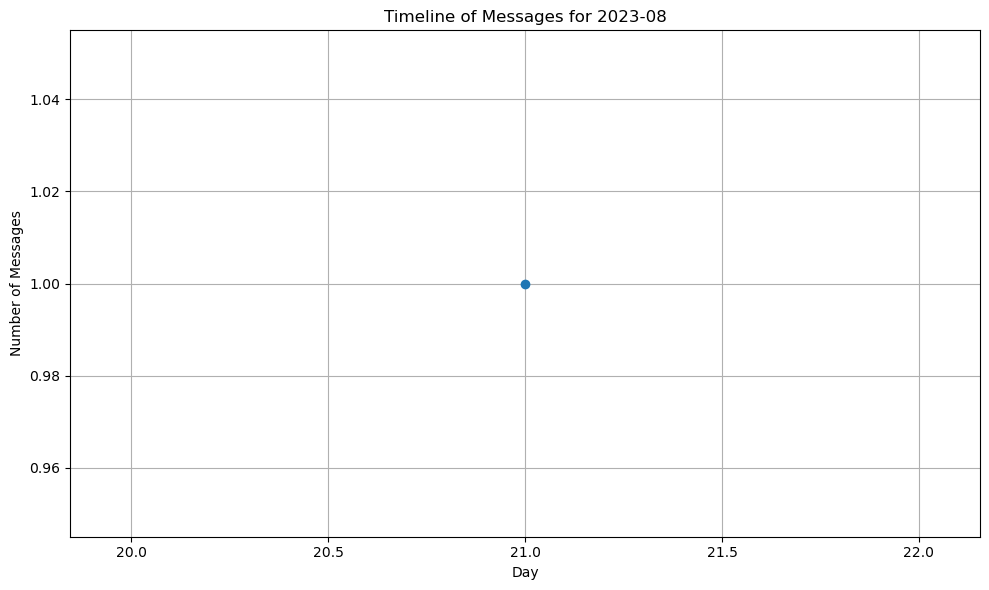

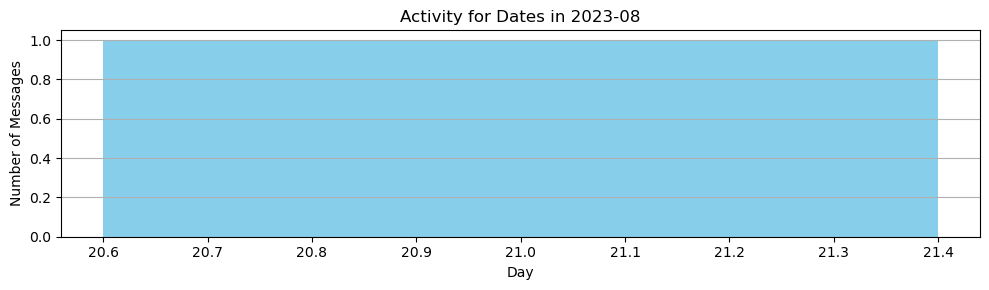

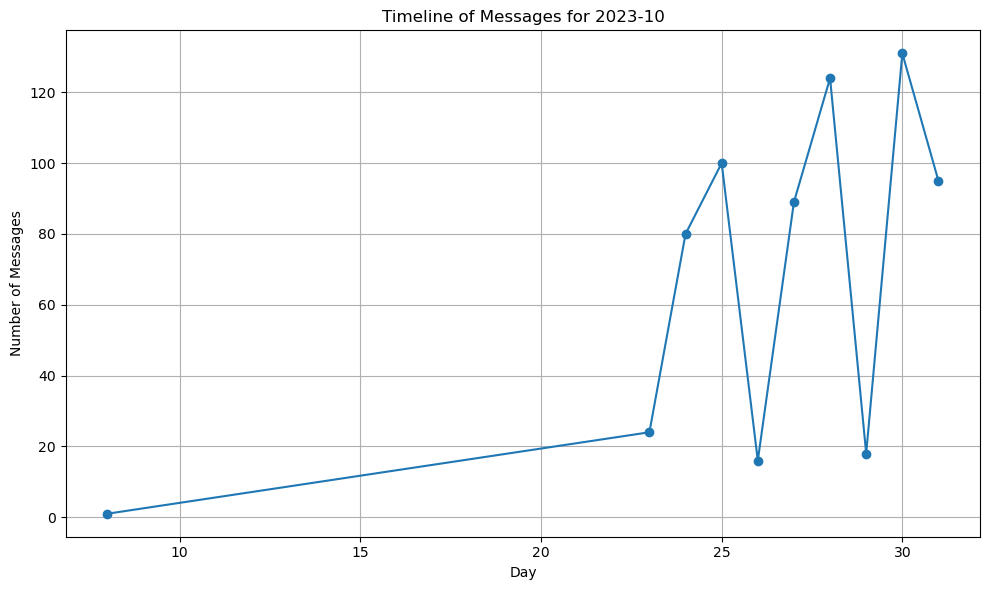

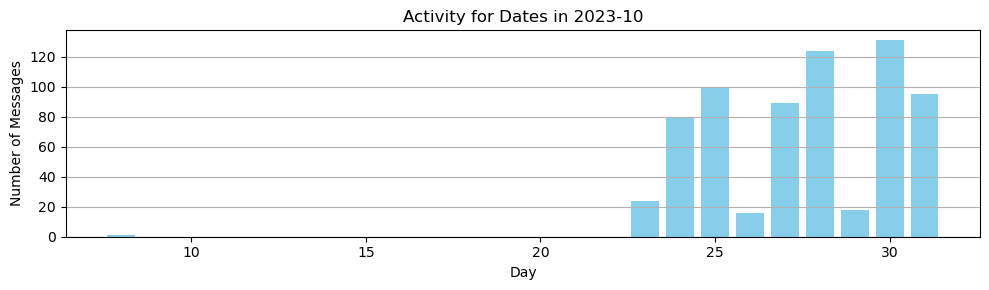

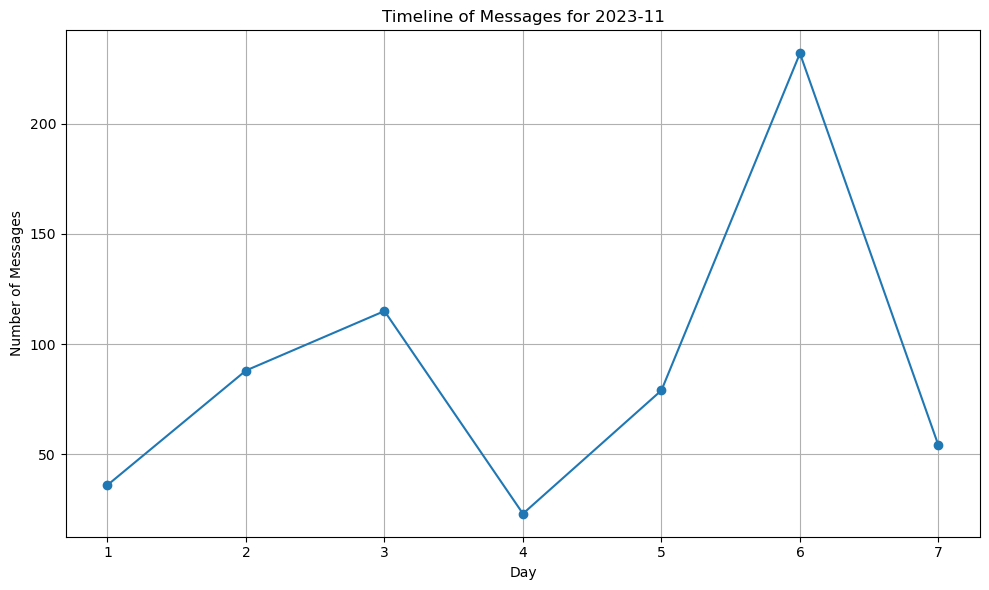

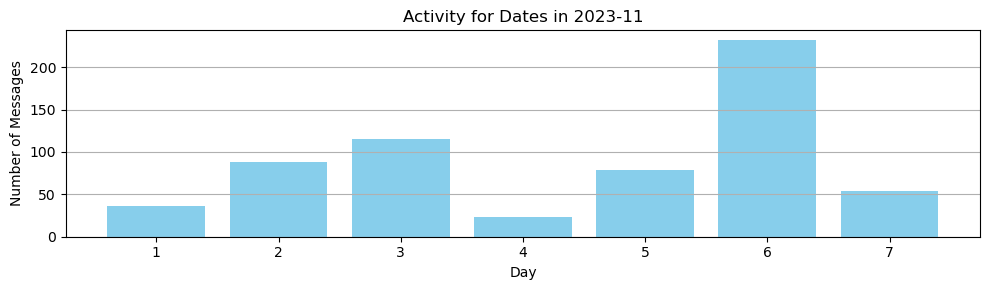

In [32]:
import matplotlib.pyplot as plt

# Group the data by Year and Month and count the number of messages in each month
monthly_counts = df_filtered.groupby(['Year', 'Month']).size().reset_index(name='Message Count')

# Iterate over each month and plot the timeline
for index, row in monthly_counts.iterrows():
    year = row['Year']
    month = row['Month']
    month_data = df_filtered[(df_filtered['Year'] == year) & (df_filtered['Month'] == month)]
    
    # Group the data by Day and count the number of messages for each day
    daily_counts = month_data.groupby('Day').size().reset_index(name='Message Count')
    
    # Plot the timeline for the current month
    plt.figure(figsize=(10, 6))
    plt.plot(daily_counts['Day'], daily_counts['Message Count'], marker='o', linestyle='-')
    plt.title(f'Timeline of Messages for {year}-{month:02d}')
    plt.xlabel('Day')
    plt.ylabel('Number of Messages')
    plt.grid(True)
    plt.tight_layout()
    
    # Display the dates and their activity
    plt.figure(figsize=(10, 3))
    plt.bar(daily_counts['Day'], daily_counts['Message Count'], color='skyblue')
    plt.title(f'Activity for Dates in {year}-{month:02d}')
    plt.xlabel('Day')
    plt.ylabel('Number of Messages')
    plt.grid(axis='y')
    plt.tight_layout()
    
    plt.show()


## אחרי בדיקה בפיקוד העורף בחודש אוקטובר היו אזעקות מה23.10 ואכן ניתן לראות כי הפעילות בקבוצה גברה

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\692246015.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_active_day_data['Hour'] = most_active_day_data['Timestamp'].dt.hour


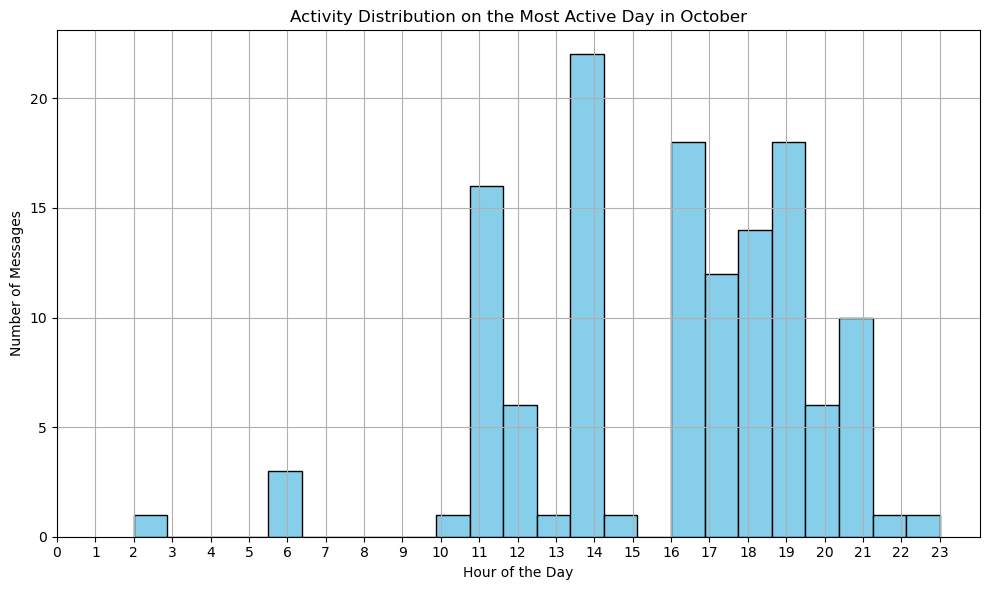

In [33]:
import matplotlib.pyplot as plt

# Filter the data for month 10
october_data = df_filtered[(df_filtered['Year'] == 2023) & (df_filtered['Month'] == 10)]

# Group the data by day and count the number of messages for each day
daily_counts = october_data.groupby('Day').size().reset_index(name='Message Count')

# Find the date with the maximum number of messages
most_active_date = daily_counts.loc[daily_counts['Message Count'].idxmax()]
most_active_day = most_active_date['Day']

# Plot the activity over time for the most active date
most_active_day_data = october_data[october_data['Day'] == most_active_day]
most_active_day_data['Hour'] = most_active_day_data['Timestamp'].dt.hour

plt.figure(figsize=(10, 6))
plt.hist(most_active_day_data['Hour'], bins=24, color='skyblue', edgecolor='black')
plt.title(f'Activity Distribution on the Most Active Day in October')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()


## ניתן לראות כי בשעות שהיו התרעות הפעילות בקבוצה גברה


C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


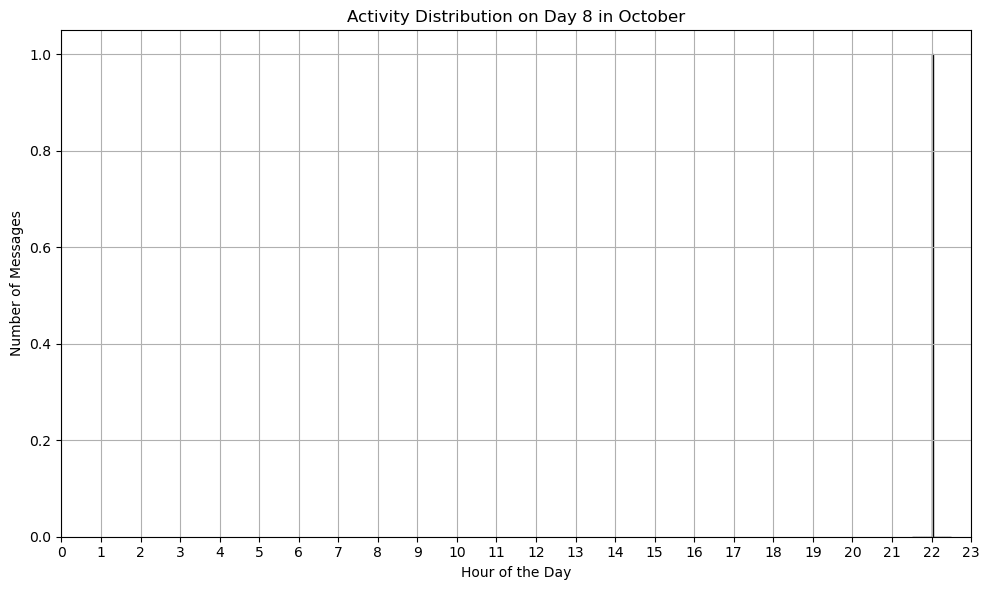

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


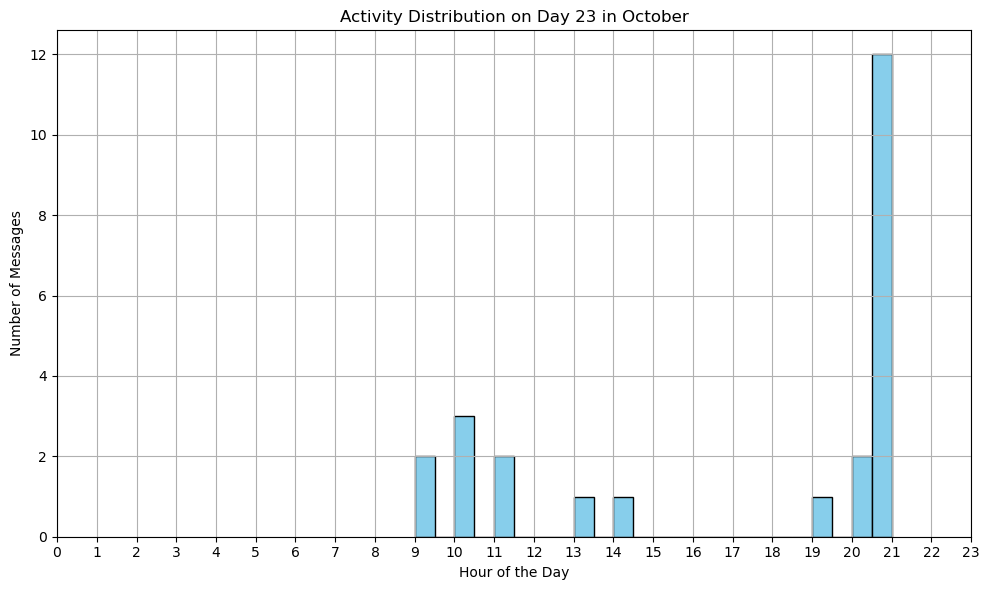

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


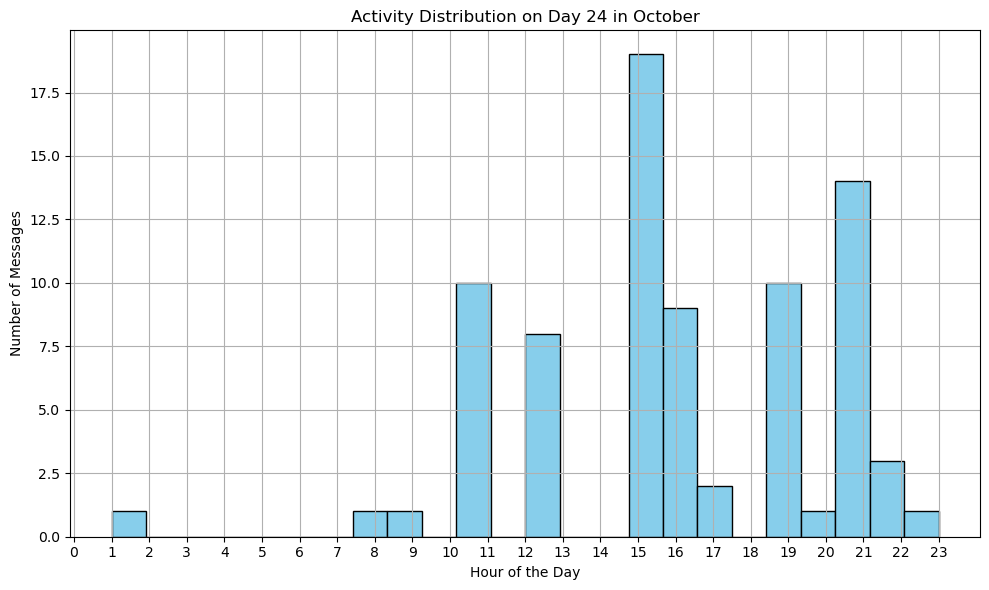

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


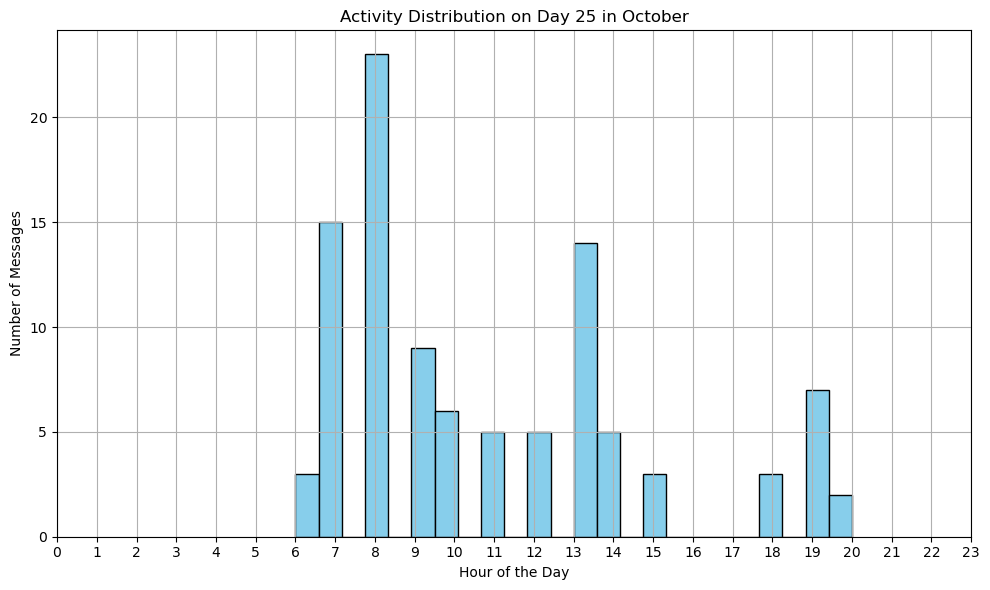

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


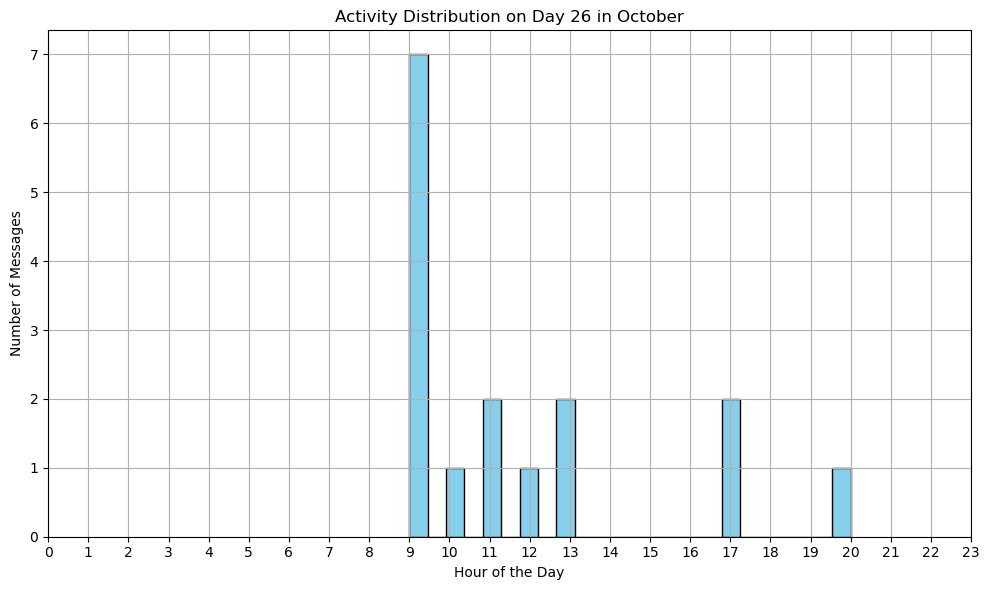

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


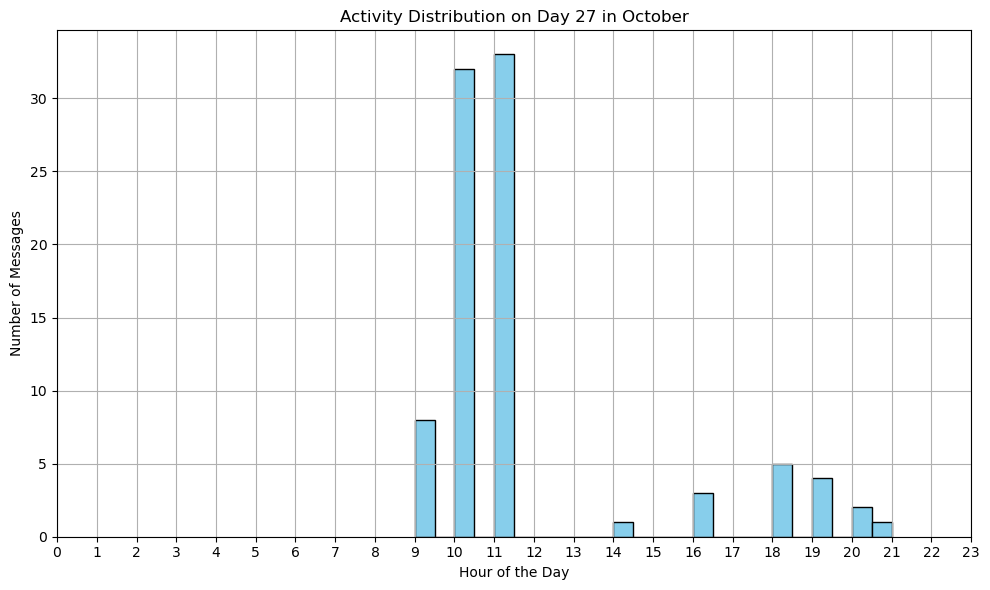

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


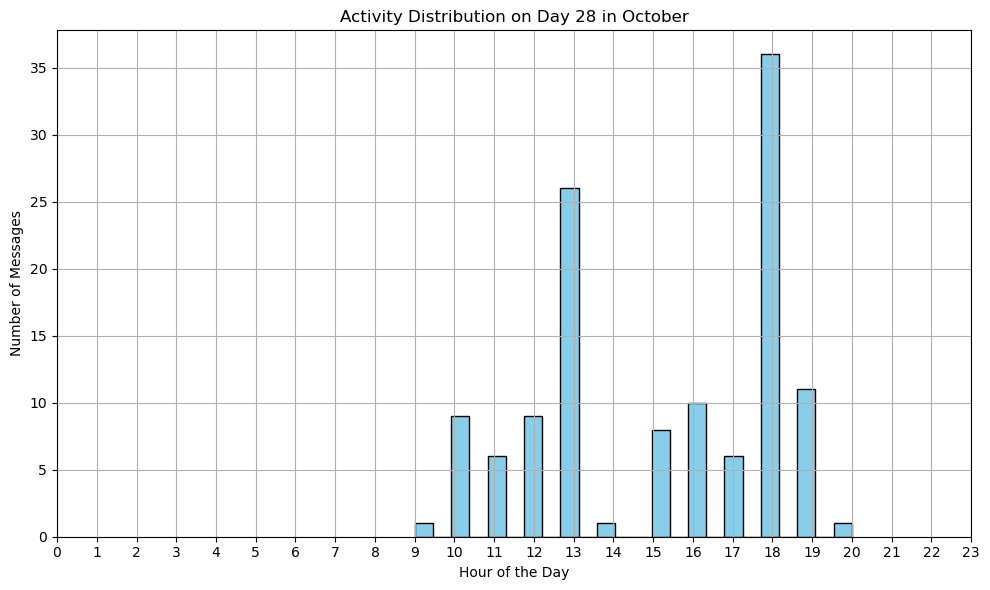

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


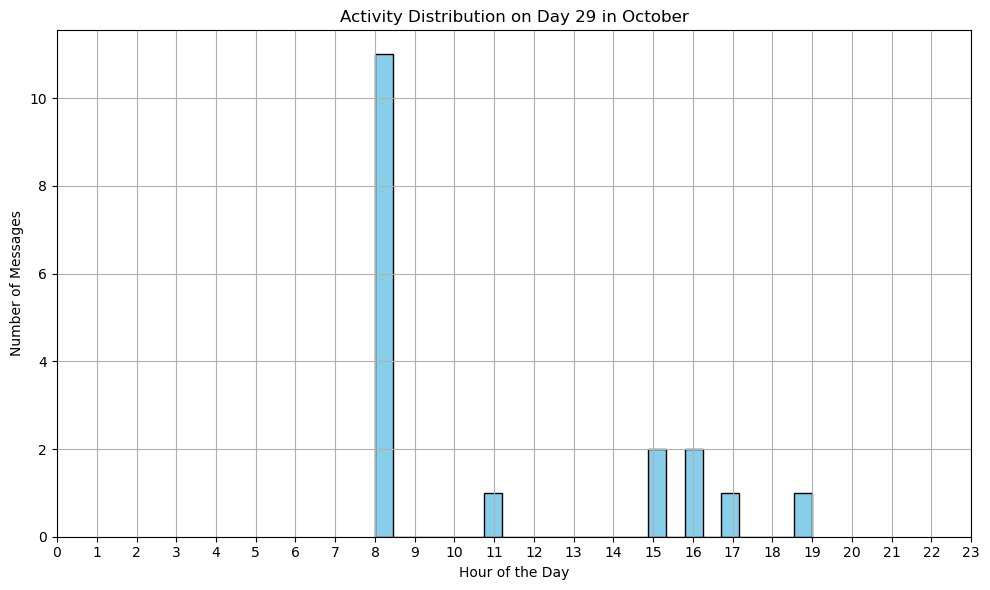

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


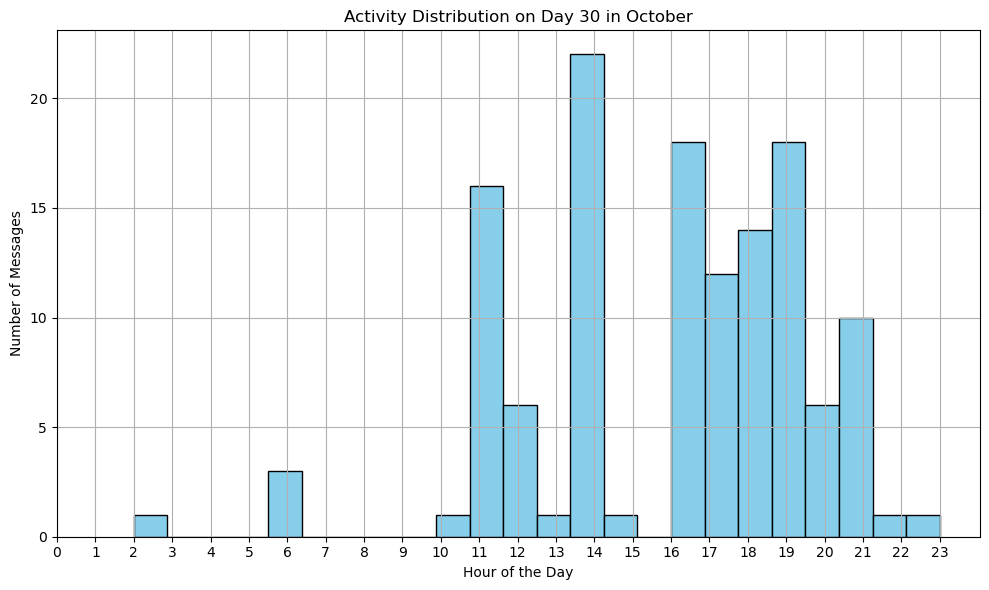

C:\Users\97254\AppData\Local\Temp\ipykernel_26704\3199023157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['Hour'] = day_data['Timestamp'].dt.hour


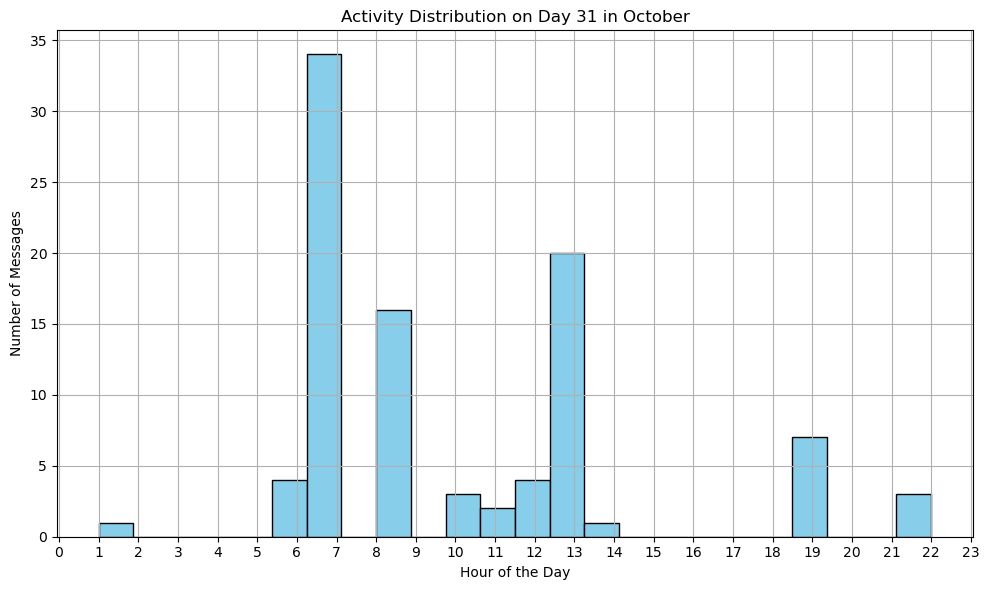

In [34]:
import matplotlib.pyplot as plt

# Filter the data for month 10
october_data = df_filtered[(df_filtered['Year'] == 2023) & (df_filtered['Month'] == 10)]

# Group the data by day and count the number of messages for each day
daily_counts = october_data.groupby('Day').size().reset_index(name='Message Count')

# Iterate over each day in October and plot the activity over time
for index, row in daily_counts.iterrows():
    day = row['Day']
    day_data = october_data[october_data['Day'] == day]
    day_data['Hour'] = day_data['Timestamp'].dt.hour
    
    plt.figure(figsize=(10, 6))
    plt.hist(day_data['Hour'], bins=24, color='skyblue', edgecolor='black')
    plt.title(f'Activity Distribution on Day {day} in October')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Messages')
    plt.xticks(range(24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## בתאריכים שמופיעים מעל , שוחררו חטופים והתעסקו בשחרור חטופים נוספים

In [37]:
# Filter the data for month 10
october_data = df_filtered[(df_filtered['Year'] == 2023) & (df_filtered['Month'] == 10)]

# Filter the data for messages containing the word 'חטוף' or 'חטופים'
keyword_data = october_data[october_data['Message'].str.contains('חטוף|חטופים|אזעקה', na=False)]

# Print the dates where the keyword appeared
dates_with_keyword = keyword_data['Timestamp'].dt.date.unique()
print("Dates where the word 'חטוף' or 'חטופים' or 'אזעקה' appeared in October:")
for date in dates_with_keyword:
    print(date)


Dates where the word 'חטוף' or 'חטופים' or 'אזעקה' appeared in October:
2023-10-24
2023-10-25
2023-10-27
2023-10-28
2023-10-29
2023-10-30
2023-10-31
